In [1]:
import matplotlib.pyplot as plt
import pylab
import math
import copy
import os
import time
import warnings
import numpy as np


from IPython.display import clear_output

import sys
sys.path.append("C:\\Users\\artur\\Desktop\\QAE")

from matplotlib import set_loglevel
set_loglevel("error")
%matplotlib inline

from qae_utils.Files import create_folder_if_needed, read_json_file, read_ts_file
from qae_utils.Charts import multi_plot_flat_ts, meas_plot
from qae_utils.Tools import draw_circuit
from qae_utils.Window import ts_wind_make, ts_wind_split, ts_wind_flatten_avg
from qae_utils.Window import ts_calc_noise, ts_add_noise
from qae_utils.Files import read_pickle_file
from qae_utils.Files import write_pickle_file

In [2]:
## Software version
major_version = 6
minor_version = 0

### Mmackey-Glass settings
beta=0.25    # Larger beta = stronger oscillations
gamma=0.1    # Keeps damping moderate
n=10         # Standard nonlinearity
tau=15       # Introduces chaos (try 17–30 for interesting behavior)
dt=1.0       # Coarse step (creates irregularities due to Euler integration)
T=300        # 300 steps (since dt=1.0, T=300 gives 300 values)

### Data encoding
margin = 0.2
scale_low = 0+margin
scale_high = 1 - margin

In [3]:
def scale_values(x, new_min=0, new_max=1):
    x_min, x_max = np.min(x), np.max(x)
    return new_min + (x - x_min) * (new_max - new_min) / (x_max - x_min)

In [4]:
import numpy as np
import matplotlib.pyplot as plt

### Simulates the Mackey-Glass time series using the 4th-order Runge-Kutta method.
def mackey_glass(beta=0.2, gamma=0.1, n=10, tau=17, dt=0.1, T=1000):
    
    N = int(T / dt)                # Total number of time steps
    delay_steps = int(tau / dt)    # Delay in terms of steps
    x = np.zeros(N + delay_steps)  # Initialize time series with zeros
    x[0:delay_steps] = 1.2         # Initial condition

    for t in range(delay_steps, N + delay_steps - 1):
        x_tau = x[t - delay_steps]  # Delayed term
        dxdt = beta * x_tau / (1 + x_tau**n) - gamma * x[t]  # Mackey-Glass equation
        x[t + 1] = x[t] + dxdt * dt  # Euler integration

    return x[delay_steps:]  # Return only the valid part of the time series

# Generate and plot the Mackey-Glass time series
y_raw = mackey_glass(beta=beta, gamma=gamma, n=n, tau=tau, dt=dt, T=T)
y_raw = scale_values(y_raw, new_min=scale_low, new_max=scale_high)
y = y_raw[2::3]
X = np.array([i for i in range(len(y))])

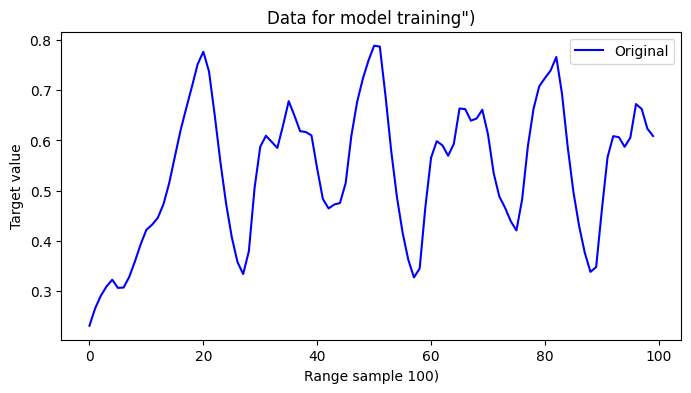

In [5]:
### Plot loaded TSs
X_list = [0]
y_list = [y]

# print(f'y_train_ts.shape = {y_train_ts.shape}')
# print(f'y_test_ts.shape = {y_test_ts.shape}')

print()
multi_plot_flat_ts(y_list, X_list=X_list,
    colors = ['blue'],
    labels = ['Original'],
    lines = ['solid'], legend_cols=1, 
    rcParams=(8, 4), #ylim=(0, 3.5),
    xlabel=f'Range sample 100)',
    title=f'Data for model training")'
    )
print()

In [6]:
### Run specific architectural + training param
#   These parameter values can be set from the test data

### Data params

samples = 100
split = 0.75
train_size = int(samples*split)     # Use the first train_size points for training
test_size = samples - train_size    # Use the next test_size points for testing

wind_size = 5
wind_step = 2
horizon = 1

noise = 0.1 # This is max absolute, in relation to value range (0, 1)

### Model params
rot = 'Rxyz' # Ry / Rxyz
n_layers = 3
n_latent = 3
n_extra = 2
n_epochs = 100 # 1000 # 2000
log_interv = 1
param_scaler = 0.1

### Derived params
n_trash = wind_size - n_latent
n_data = n_latent + n_trash
n_wires = n_latent + n_trash + n_extra

### Other (CASE_NAME) invariant params
diff_method = 'best'
interface = None # we will use default
level='gradient'
shuffle_interv = 0
cost_type = 'MSE'
cost_yscale = 'linear' # linear, log
shots = None # We use a state vector simulator

### Currently are not generated here, but QAE models should run 10 times with diff inits
#   The number of times the model should be run with different initial params
#   Each instance history and params should be saved and later used
n_inst = 1

### Random seed(s)
#   We may need to create different seeds for each model instance

seed = 2024

if seed == 0: 
    np.random.seed(rand_seed())
else:
    np.random.seed(seed)
inst_seeds = [int(n) for n in np.random.randint(0, high=9999, size=n_inst)]

In [5]:
### Libraries used in QAE development

# PennyLane imports
import pennylane as qml
from pennylane import numpy as np

In [8]:
### Quantum simulator
sim = 'default.qubit' # default.qubit lightning.qubit lightning.gpu

In [8]:
### Create time series tensor data with optional noise (note that windows overlap by wind_step)
def create_sw_tens(X, y, noise=0.0, wind_size=5, wind_step=2):
    y_ts = ts_wind_make(ts_add_noise(y, noise), wind_size, wind_step)
    X_ts = np.array([i*wind_step for i in range(len(y_ts))])
    X_train_ts, y_train_ts, X_test_ts, y_test_ts = ts_wind_split(X_ts, y_ts, split)

    X_train_tens = np.tensor(X_train_ts, requires_grad=False)
    y_train_tens = np.tensor(y_train_ts, requires_grad=False)
    X_test_tens = np.tensor(X_test_ts, requires_grad=False)
    y_test_tens = np.tensor(y_test_ts, requires_grad=False)
    return X_train_tens, y_train_tens, X_test_tens, y_test_tens

In [9]:
### Our own gradient-friendly loss/cost function
#   Beware in PennyLane these MUST be very pure
#   to be differentiable (so not external / fancy functions)
def mse_cost_on_tensors(targets, predictions):
    cost = 0
    vals = 0
    for i in range(len(targets)):
        for w in range(len(targets[i])):
            cost = cost + (targets[i][w] - predictions[i][w]) ** 2
            vals += 1
    cost = cost / vals
    return cost

### The cost function generator
def cost_fun_gen_on_tensors(model, cost_fun):
    def _cost_fun(params, inputs, targets):
        nonlocal model, cost_fun
        preds = [model(params, x) for x in inputs]
        return cost_fun(targets, preds)
    return _cost_fun

In [11]:
##### Prepare for training

### For reproducibility
np.random.seed(seed)

### Select one of the following optimisers built into PennyLane
# opt = qml.GradientDescentOptimizer(stepsize=0.5)
# opt = qml.RMSPropOptimizer(stepsize=0.1, decay=0.7, eps=1e-08)
# opt = qml.NesterovMomentumOptimizer(stepsize=0.5)
# opt = RCDOptimizer(h=0.1)
opt = qml.AdamOptimizer(stepsize=0.5)

In [12]:
### Half QAE unified shape
#   n_latent: number of latent qubits
#   n_trash: number of trash qubits
#   n_layers: number of layers (repeats)
#   returns: shape
def half_qae_shape_unified(n_latent, n_trash, n_extra=0, n_layers=1, rot='Ry'):
    n_wires = n_latent + n_trash + n_extra
    if rot == 'Ry':
        shape = qml.BasicEntanglerLayers.shape(n_layers=n_layers, n_wires=n_wires)
    elif  rot == 'Rxyz':
        shape = qml.StronglyEntanglingLayers.shape(n_layers=n_layers, n_wires=n_wires)
    return shape

In [13]:
def half_qae_unified(wires, n_latent, n_trash, n_layers=1, rot='Ry', dagger=False):
    latent_wires = wires[:n_latent]
    trash_wires  = wires[n_latent:n_latent+n_trash]
    data_wires   = latent_wires + trash_wires
    anz_wires    = data_wires

    def _sequence_encoder(wires, inputs):
        n_inputs = len(inputs)
        for w in wires:
            if w > n_inputs-1:
                qml.RY(0, wires=w)
            else:
                qml.RY(inputs[w], wires=w)

    def _entangler_shape(n_layers, n_wires, rot='Ry'):
        if rot == 'Ry':
            return qml.BasicEntanglerLayers.shape(n_layers=n_layers, n_wires=n_wires)
        elif rot == 'Rxyz':
            return qml.StronglyEntanglingLayers.shape(n_layers=n_layers, n_wires=n_wires)
        else:
            return ()

    def _entangler(wires, weights, rot='Ry'):
        if rot == 'Ry':
            qml.BasicEntanglerLayers(weights, wires=anz_wires, rotation=qml.RY)
        elif rot == 'Rxyz':
            qml.StronglyEntanglingLayers(weights, wires=anz_wires)

    def _half_qae_unified(weights, inputs):
        _sequence_encoder(data_wires, inputs)
        qml.Barrier(wires)
        shape = _entangler_shape(n_layers, len(anz_wires), rot=rot)
        w = weights.reshape(shape)
        if dagger:
            qml.adjoint(_entangler)(anz_wires, w, rot=rot)
            return [qml.expval(qml.PauliZ(w)) for w in latent_wires + trash_wires]
        else:
            _entangler(anz_wires, w, rot=rot)
            return [qml.expval(qml.PauliZ(w)) for w in trash_wires]

    return _half_qae_unified

In [14]:
##### Create a model

wires = list(range(n_latent + n_trash))

### Check the HALF QAE shape
shape = half_qae_shape_unified(n_latent, n_trash, n_layers=n_layers, rot=rot)
n_weights = np.prod(shape)
print(f'Half-QAE unified shape: {shape}, weights: {int(n_weights)}\n')
sample_params = np.random.uniform(high=param_scaler, size=shape, requires_grad=True)
sample_data = np.linspace(100, 200, n_latent + n_trash, requires_grad=False)

Half-QAE unified shape: (3, 5, 3), weights: 45



In [15]:
qae = half_qae_unified(wires, n_latent, n_trash, n_layers=n_layers, rot=rot, dagger=False)
dev = qml.device(sim, wires=wires, shots=shots, seed=seed)
half_qae_model_unified = qml.QNode(qae, dev)

In [16]:
##### Training loop

def train_with_noise_trash(model, X, y, loss_fun, optimizer, n_epochs, init_weights=None, 
                     log_interv=100, prompt_fract=0.1, start_time=0, level=2, seed=0,
                     wind_size=8, wind_step=4, noise=0, weight_scaler=0.1):

    ### For reproducibility
    #   Set a default random seed
    if seed == 0: seed = int(time.time()*1000) % 10000
    np.random.seed(seed)
    
    ### Define the cost function
    cost_fun = cost_fun_gen_on_tensors(model, loss_fun)
    
    ### Prepare training
    hist_cost = []
    hist_params = []
    
    ### Set initial weights/parameters
    if init_weights is None:
        init_weights = np.random.uniform(high=np.pi, size=shape, requires_grad=True)*weight_scaler
    params = init_weights.copy()
    
    ### Prepare tensors of pure training windows to be used as y output
    #   We ignore the test partition in training
    _, y_pure_tens, _, _ = create_sw_tens(X, y, noise=0, 
        wind_size=wind_size, wind_step=wind_step)
    y_trash_tens = np.zeros((len(y_train_pure_tens), n_trash))
    
    ### Set the clock
    if start_time == 0: start_time = time.time() 
        
    ### Training loop
    for iter in range(n_epochs):
    
        # Add noise to pure windows to be used as X input
        #   We ignore the test partition in training
        _, X_noisy_tens, _, _ = create_sw_tens(X, y, noise=noise, 
            wind_size=wind_size, wind_step=wind_step)
    
        params, cost = optimizer.step_and_cost(lambda p: cost_fun(p, X_noisy_tens, y_trash_tens), params)
        elapsed_time = time.time()-start_time
        if iter % log_interv == 0:
            hist_cost.append(cost)
            hist_params.append(params)
        if (prompt_fract == 0) or (iter % int(prompt_fract*n_epochs) == 0):
            print(f'Iter: {iter:03d} ({int(elapsed_time):03d} sec) cost={np.round(cost, 6)}')
    
    ### Print the training summary
    min_cost = np.min(hist_cost)
    min_iter = np.argmin(hist_cost)
    opt_params = hist_params[min_iter]
    
    ### Print the training summary
    print(f'\nTraining completed: epochs={n_epochs}, min cost={np.round(min_cost, 6)} @ {min_iter}, time={int(elapsed_time):03d} secs\n')

    return hist_cost, hist_params, init_weights, (min_iter, min_cost, elapsed_time)

In [17]:
_, y_train_pure_tens, _, _ = create_sw_tens(X, y, noise=0, wind_size=wind_size, wind_step=wind_step)

In [18]:
hist_cost, hist_params, init_weights, stats = train_with_noise_trash(
    half_qae_model_unified,
    X, y, mse_cost_on_tensors, opt, n_epochs,
    wind_size=wind_size, wind_step=wind_step, noise=noise,
    log_interv=log_interv, prompt_fract=0.1, start_time=0, level=2, seed=seed
)

Iter: 000 (001 sec) cost=0.183166
Iter: 010 (013 sec) cost=0.008016
Iter: 020 (024 sec) cost=0.001202
Iter: 030 (035 sec) cost=0.000311
Iter: 040 (046 sec) cost=0.000142
Iter: 050 (057 sec) cost=2e-05
Iter: 060 (068 sec) cost=2.2e-05
Iter: 070 (079 sec) cost=1.2e-05
Iter: 080 (091 sec) cost=5e-06
Iter: 090 (102 sec) cost=5e-06

Training completed: epochs=100, min cost=3e-06 @ 97, time=112 secs



In [19]:
# params of model
best_params = hist_params[stats[0]]
best_params_flip = np.flip(best_params, axis=0)

In [20]:
qae = half_qae_unified(wires, n_latent, n_trash, n_layers=n_layers, rot=rot, dagger=True)
dev = qml.device(sim, wires=wires, shots=shots, seed=seed)
half_qae_model_unified = qml.QNode(qae, dev)

In [21]:
##### Training loop

def train_with_noise(model, X, y, loss_fun, optimizer, n_epochs, init_weights=None, 
                     log_interv=100, prompt_fract=0.1, start_time=0, level=2, seed=0,
                     wind_size=8, wind_step=4, noise=0, weight_scaler=0.1):

    ### For reproducibility
    #   Set a default random seed
    if seed == 0: seed = int(time.time()*1000) % 10000
    np.random.seed(seed)
    
    ### Define the cost function
    cost_fun = cost_fun_gen_on_tensors(model, loss_fun)
    
    ### Prepare training
    hist_cost = []
    hist_params = []
    
    ### Set initial weights/parameters
    if init_weights is None:
        init_weights = np.random.uniform(high=np.pi, size=shape, requires_grad=True)*weight_scaler
    params = init_weights.copy()
    
    ### Prepare tensors of pure training windows to be used as y output
    #   We ignore the test partition in training
    _, y_pure_tens, _, _ = create_sw_tens(X, y, noise=0, 
        wind_size=wind_size, wind_step=wind_step)
    
    ### Set the clock
    if start_time == 0: start_time = time.time() 
        
    ### Training loop
    for iter in range(n_epochs):
    
        # Add noise to pure windows to be used as X input
        #   We ignore the test partition in training
        _, X_noisy_tens, _, _ = create_sw_tens(X, y, noise=noise, 
            wind_size=wind_size, wind_step=wind_step)
    
        params, cost = optimizer.step_and_cost(lambda p: cost_fun(p, X_noisy_tens, y_pure_tens), params)
        elapsed_time = time.time()-start_time
        if iter % log_interv == 0:
            hist_cost.append(cost)
            hist_params.append(params)
        if (prompt_fract == 0) or (iter % int(prompt_fract*n_epochs) == 0):
            print(f'Iter: {iter:03d} ({int(elapsed_time):03d} sec) cost={np.round(cost, 6)}')
    
    ### Print the training summary
    min_cost = np.min(hist_cost)
    min_iter = np.argmin(hist_cost)
    opt_params = hist_params[min_iter]
    
    ### Print the training summary
    print(f'\nTraining completed: epochs={n_epochs}, min cost={np.round(min_cost, 6)} @ {min_iter}, time={int(elapsed_time):03d} secs\n')

    return hist_cost, hist_params, init_weights, (min_iter, min_cost, elapsed_time)

In [22]:
hist_cost, hist_params, init_weights, stats = train_with_noise(
    half_qae_model_unified,
    X, y, mse_cost_on_tensors, opt, n_epochs, init_weights=best_params_flip,
    wind_size=wind_size, wind_step=wind_step, noise=noise,
    log_interv=log_interv, prompt_fract=0.1, start_time=0, level=2, seed=seed
)

Iter: 000 (001 sec) cost=0.42893
Iter: 010 (013 sec) cost=0.044
Iter: 020 (025 sec) cost=0.013468
Iter: 030 (038 sec) cost=0.009245
Iter: 040 (050 sec) cost=0.007231
Iter: 050 (063 sec) cost=0.006082
Iter: 060 (076 sec) cost=0.005738
Iter: 070 (088 sec) cost=0.004571
Iter: 080 (101 sec) cost=0.003892
Iter: 090 (113 sec) cost=0.003271

Training completed: epochs=100, min cost=0.003223 @ 98, time=124 secs



In [23]:
best_params_dagger = hist_params[stats[0]]

In [24]:
### Add noise to pure data to create a sample noisy data

# Create a sample of pure and noisy training and test tensors
X_train_pure_tens, y_train_pure_tens, X_test_pure_tens, y_test_pure_tens = \
    create_sw_tens(X, y, noise=0, wind_size=wind_size, wind_step=wind_step)
X_train_noisy_tens, y_train_noisy_tens, X_test_noisy_tens, y_test_noisy_tens = \
    create_sw_tens(X, y, noise=noise, wind_size=wind_size, wind_step=wind_step)

# Flatten original TSs for plotting
y_train_pure_flat = ts_wind_flatten_avg(y_train_pure_tens, wind_step)
y_test_pure_flat = ts_wind_flatten_avg(y_test_pure_tens, wind_step)
y_train_noisy_flat = ts_wind_flatten_avg(y_train_noisy_tens, wind_step)
y_test_noisy_flat = ts_wind_flatten_avg(y_test_noisy_tens, wind_step)

In [25]:
### Reconstruct pure and noisy training TSs
pred_train_from_pure_tens = np.stack([half_qae_model_unified(best_params_dagger, x) for x in y_train_pure_tens], requires_grad=False)
pred_test_from_pure_tens = np.stack([half_qae_model_unified(best_params_dagger, x) for x in y_test_pure_tens], requires_grad=False)
pred_train_from_noisy_tens = np.stack([half_qae_model_unified(best_params_dagger, x) for x in y_train_noisy_tens], requires_grad=False)
pred_test_from_noisy_tens = np.stack([half_qae_model_unified(best_params_dagger, x) for x in y_test_noisy_tens], requires_grad=False)

### Flatten recovered TSs
pred_train_from_pure_flat = ts_wind_flatten_avg(pred_train_from_pure_tens, wind_step)
pred_test_from_pure_flat = ts_wind_flatten_avg(pred_test_from_pure_tens, wind_step)
pred_train_from_noisy_flat = ts_wind_flatten_avg(pred_train_from_noisy_tens, wind_step)
pred_test_from_noisy_flat = ts_wind_flatten_avg(pred_test_from_noisy_tens, wind_step)

In [26]:
### Calculate metrics to show in charts
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
mse_train_pure_vs_noisy = mean_squared_error(y_train_pure_flat, y_train_noisy_flat)
mse_train_pure_vs_rec_from_noisy = mean_squared_error(y_train_pure_flat, pred_train_from_noisy_flat)
mse_test_pure_vs_noisy = mean_squared_error(y_test_pure_flat, y_test_noisy_flat)
mse_test_pure_vs_rec_from_noisy = mean_squared_error(y_test_pure_flat, pred_test_from_noisy_flat)

print(f'MSE train pure vs noise vs recovered = {mse_train_pure_vs_noisy:0.8f}, {mse_train_pure_vs_rec_from_noisy:0.8f}')
print(f'MSE test  pure vs noise vs recovered = {mse_test_pure_vs_noisy:0.8f}, {mse_test_pure_vs_rec_from_noisy:0.8f}')

MSE train pure vs noise vs recovered = 0.00310998, 0.00249864
MSE test  pure vs noise vs recovered = 0.00316873, 0.00215501


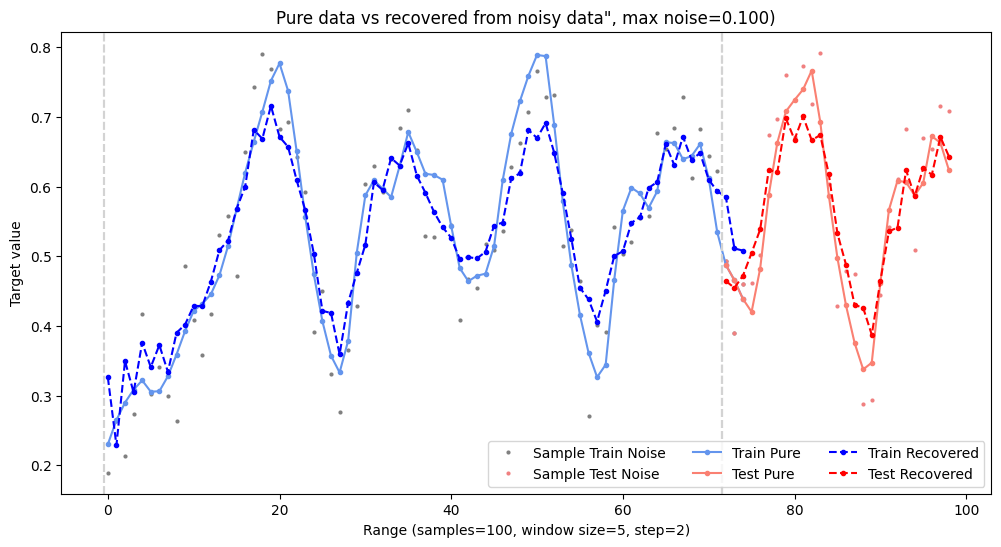

In [27]:
### Plot the original and recovered data with added performance metrics

# Prepare X, y lists for plotting
X_list = [X_train_pure_tens[0], X_test_pure_tens[0], 
          X_train_pure_tens[0], X_test_pure_tens[0], 
          X_train_pure_tens[0], X_test_pure_tens[0]]
y_list = [y_train_noisy_flat, y_test_noisy_flat,
          y_train_pure_flat, y_test_pure_flat, 
          pred_train_from_noisy_flat, pred_test_from_noisy_flat]

print()
multi_plot_flat_ts(
    y_list, X_list=X_list,
    colors=['none', 'none', 'cornflowerblue', 'salmon', 'blue', 'red'],
    marker_colors=['gray', 'lightcoral', 'cornflowerblue', 'salmon', 'blue', 'red'],
    labels=[
        'Sample Train Noise',
        'Sample Test Noise',
        'Train Pure',
        'Test Pure',
        'Train Recovered',
        'Test Recovered'
    ],
    lines=['dotted', 'dotted', 'solid', 'solid', 'dashed', 'dashed'],
    markers=['.', '.', '.', '.', '.', '.'],
    legend_cols=3,
    title=f'Pure data vs recovered from noisy data\", max noise={noise:0.3f})',
    xlabel=f'Range (samples={samples}, window size={wind_size}, step={wind_step})',
    #save_plot=f'{FIGURES_PATH}/{TRAIN_PREF}/train_org_vs_recovered.eps'
)
print()

In [28]:
from scipy.signal import wiener, savgol_filter, butter, filtfilt, medfilt

In [29]:
from scipy.signal import wiener, savgol_filter, butter, filtfilt, medfilt

# Original signal: y_train_pure_flat
# Noisy signal: y_train_noisy_flat

# Wiener filter
filtered_wiener = wiener(y_train_noisy_flat)

# Savitzky-Golay filter
filtered_savgol = savgol_filter(y_train_noisy_flat, window_length=7, polyorder=2)

# Butterworth (low-pass)
b, a = butter(N=3, Wn=0.1)
filtered_butter = filtfilt(b, a, y_train_noisy_flat)

# Median filter
filtered_median = medfilt(y_train_noisy_flat, kernel_size=5)

# Moving average
window = 5
filtered_ma = np.convolve(y_train_noisy_flat, np.ones(window)/window, mode='same')

# MSE comparison
from sklearn.metrics import mean_squared_error
print("Wiener MSE:", mean_squared_error(y_train_pure_flat, filtered_wiener))
print("Savitzky-Golay MSE:", mean_squared_error(y_train_pure_flat, filtered_savgol))
print("Butterworth MSE:", mean_squared_error(y_train_pure_flat, filtered_butter))
print("Median MSE:", mean_squared_error(y_train_pure_flat, filtered_median))
print("Moving average MSE:", mean_squared_error(y_train_pure_flat, filtered_ma))
print("Quantum autoencoder MSE:", mean_squared_error(y_train_pure_flat, pred_train_from_noisy_flat))

Wiener MSE: 0.0015353653196063014
Savitzky-Golay MSE: 0.0013271774829809162
Butterworth MSE: 0.007078050272109047
Median MSE: 0.0016947951532372833
Moving average MSE: 0.002139803444030872
Quantum autoencoder MSE: 0.002498643123159017


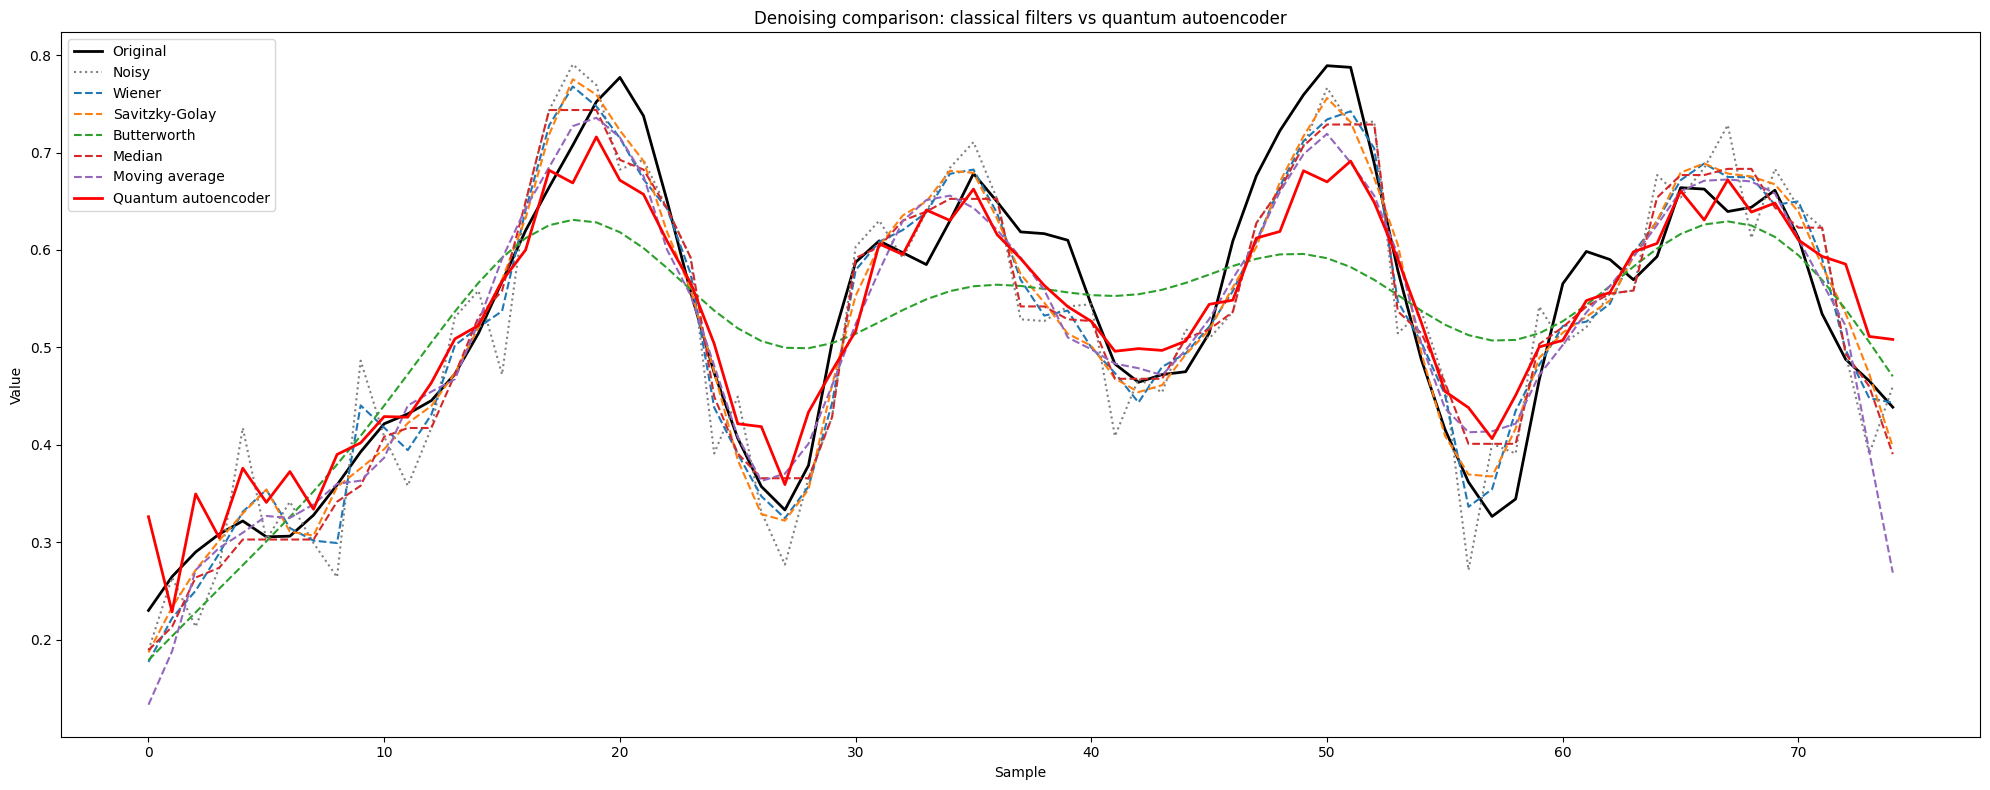

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 8))
plt.plot(y_train_pure_flat, label='Original', color='black', linewidth=2)
plt.plot(y_train_noisy_flat, label='Noisy', color='gray', linestyle='dotted')
plt.plot(filtered_wiener, label='Wiener', linestyle='dashed')
plt.plot(filtered_savgol, label='Savitzky-Golay', linestyle='dashed')
plt.plot(filtered_butter, label='Butterworth', linestyle='dashed')
plt.plot(filtered_median, label='Median', linestyle='dashed')
plt.plot(filtered_ma, label='Moving average', linestyle='dashed')
plt.plot(pred_train_from_noisy_flat, label='Quantum autoencoder', color='red', linewidth=2)

plt.legend()
plt.title('Denoising comparison: classical filters vs quantum autoencoder')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.tight_layout()
plt.show()

In [31]:
# Wiener filter
filtered_wiener = wiener(y_test_noisy_flat)

# Savitzky-Golay filter
filtered_savgol = savgol_filter(y_test_noisy_flat, window_length=7, polyorder=2)

# Butterworth (low-pass)
b, a = butter(N=3, Wn=0.1)
filtered_butter = filtfilt(b, a, y_test_noisy_flat)

# Median filter
filtered_median = medfilt(y_test_noisy_flat, kernel_size=5)

# Moving average
window = 5
filtered_ma = np.convolve(y_test_noisy_flat, np.ones(window)/window, mode='same')

# MSE comparison
from sklearn.metrics import mean_squared_error
print("Wiener MSE:", mean_squared_error(y_test_pure_flat, filtered_wiener))
print("Savitzky-Golay MSE:", mean_squared_error(y_test_pure_flat, filtered_savgol))
print("Butterworth MSE:", mean_squared_error(y_test_pure_flat, filtered_butter))
print("Median MSE:", mean_squared_error(y_test_pure_flat, filtered_median))
print("Moving average MSE:", mean_squared_error(y_test_pure_flat, filtered_ma))
print("Quantum autoencoder MSE:", mean_squared_error(y_test_pure_flat, pred_test_from_noisy_flat))

Wiener MSE: 0.0009110245069938042
Savitzky-Golay MSE: 0.0011655774221710805
Butterworth MSE: 0.008058043931493683
Median MSE: 0.002373475692743311
Moving average MSE: 0.005684841236300379
Quantum autoencoder MSE: 0.0021550065376401573


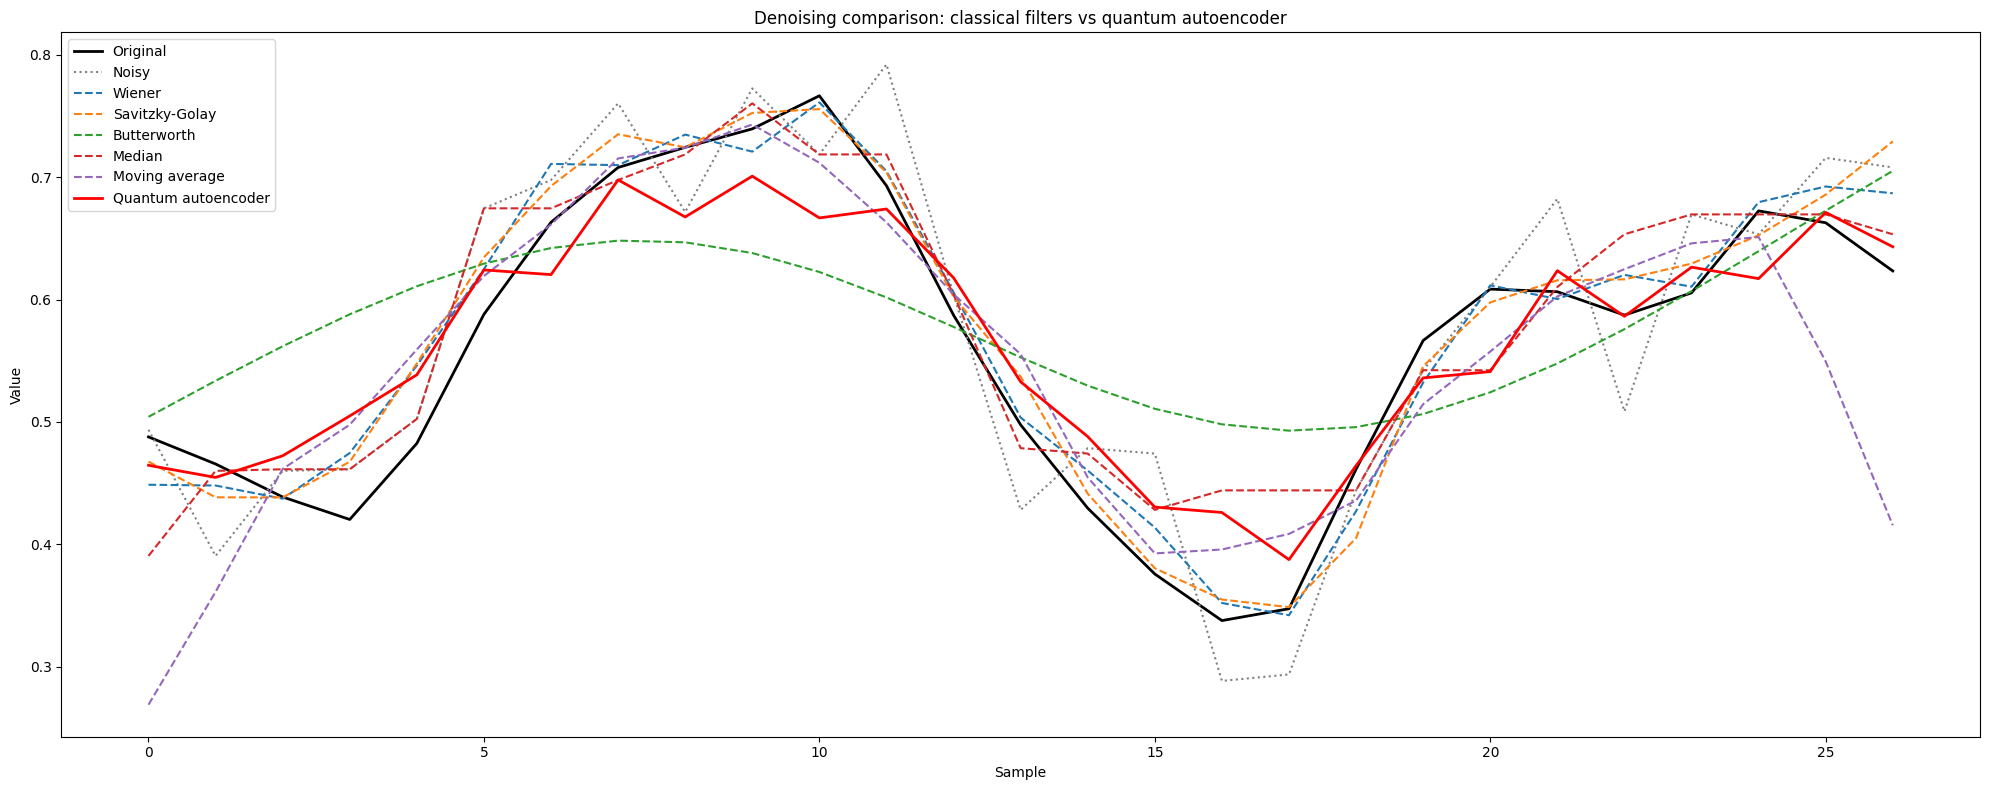

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 8))
plt.plot(y_test_pure_flat, label='Original', color='black', linewidth=2)
plt.plot(y_test_noisy_flat, label='Noisy', color='gray', linestyle='dotted')
plt.plot(filtered_wiener, label='Wiener', linestyle='dashed')
plt.plot(filtered_savgol, label='Savitzky-Golay', linestyle='dashed')
plt.plot(filtered_butter, label='Butterworth', linestyle='dashed')
plt.plot(filtered_median, label='Median', linestyle='dashed')
plt.plot(filtered_ma, label='Moving average', linestyle='dashed')
plt.plot(pred_test_from_noisy_flat, label='Quantum autoencoder', color='red', linewidth=2)

plt.legend()
plt.title('Denoising comparison: classical filters vs quantum autoencoder')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.tight_layout()
plt.show()

## K INSTANCES 

In [33]:

seed = 2025
n_inst = 5
n_epochs = 100
np.random.seed(seed)
inst_seeds = [int(s) for s in np.random.randint(0, 99999, size=n_inst)]

all_stats = []
all_mse_test = []
all_stats_dagger = []
all_mse_test_dagger = []

for i, inst_seed in enumerate(inst_seeds):
    print(f"\n=== Instance {i+1}/{n_inst}, seed={inst_seed} ===")
    np.random.seed(inst_seed)

    # ENCODER 
    qae = half_qae_unified(wires, n_latent, n_trash, n_layers=n_layers, rot=rot, dagger=False)
    dev = qml.device(sim, wires=wires, shots=shots, seed=inst_seed)
    half_qae_model_unified = qml.QNode(qae, dev)
    opt = qml.AdamOptimizer(stepsize=0.5)
    hist_cost, hist_params, init_weights, stats = train_with_noise_trash(
        half_qae_model_unified, X, y, mse_cost_on_tensors, opt, n_epochs,
        wind_size=wind_size, wind_step=wind_step, noise=noise,
        log_interv=log_interv, prompt_fract=0.1, start_time=0, level=2, seed=inst_seed
    )
    best_params = hist_params[stats[0]]
    all_stats.append(stats)

    # Reconstruction
    _, _, X_test_pure_tens, y_test_pure_tens = create_sw_tens(X, y, noise=0, wind_size=wind_size, wind_step=wind_step)
    _, _, X_test_noisy_tens, y_test_noisy_tens = create_sw_tens(X, y, noise=noise, wind_size=wind_size, wind_step=wind_step)
    pred_test_from_noisy_tens = np.stack([half_qae_model_unified(best_params, x) for x in y_test_noisy_tens], requires_grad=False)
    pred_test_from_noisy_flat = ts_wind_flatten_avg(pred_test_from_noisy_tens, wind_step)
    y_test_pure_flat = ts_wind_flatten_avg(y_test_pure_tens, wind_step)
    min_len = min(len(y_test_pure_flat), len(pred_test_from_noisy_flat))
    mse_test = mean_squared_error(y_test_pure_flat[:min_len], pred_test_from_noisy_flat[:min_len])
    all_mse_test.append(mse_test)


    # DECODER
    best_params_flip = np.flip(best_params, axis=0)
    qae_dagger = half_qae_unified(wires, n_latent, n_trash, n_layers=n_layers, rot=rot, dagger=True)
    dev_dagger = qml.device(sim, wires=wires, shots=shots, seed=inst_seed)
    half_qae_dagger_model = qml.QNode(qae_dagger, dev_dagger)
    opt_dagger = qml.AdamOptimizer(stepsize=0.5)
    hist_cost_dagger, hist_params_dagger, init_weights_dagger, stats_dagger = train_with_noise(
        half_qae_dagger_model, X, y, mse_cost_on_tensors, opt_dagger, n_epochs,
        init_weights=best_params_flip,
        wind_size=wind_size, wind_step=wind_step, noise=noise,
        log_interv=log_interv, prompt_fract=0.1, start_time=0, level=2, seed=inst_seed
    )
    best_params_dagger = hist_params_dagger[stats_dagger[0]]
    all_stats_dagger.append(stats_dagger)

    # Reconstruction
    pred_test_from_noisy_tens_dagger = np.stack([half_qae_dagger_model(best_params_dagger, x) for x in y_test_noisy_tens], requires_grad=False)
    pred_test_from_noisy_flat_dagger = ts_wind_flatten_avg(pred_test_from_noisy_tens_dagger, wind_step)
    mse_test_dagger = mean_squared_error(y_test_pure_flat, pred_test_from_noisy_flat_dagger)
    all_mse_test_dagger.append(mse_test_dagger)




=== Instance 1/5, seed=88638 ===
Iter: 000 (001 sec) cost=0.251084
Iter: 010 (012 sec) cost=0.001266
Iter: 020 (024 sec) cost=0.003647
Iter: 030 (036 sec) cost=0.000791
Iter: 040 (048 sec) cost=0.00048
Iter: 050 (060 sec) cost=9.1e-05
Iter: 060 (072 sec) cost=5e-05
Iter: 070 (084 sec) cost=6.1e-05
Iter: 080 (095 sec) cost=2.7e-05
Iter: 090 (107 sec) cost=2.6e-05

Training completed: epochs=100, min cost=1.4e-05 @ 95, time=118 secs

Iter: 000 (001 sec) cost=0.285268
Iter: 010 (014 sec) cost=0.017702
Iter: 020 (027 sec) cost=0.015667
Iter: 030 (041 sec) cost=0.007915
Iter: 040 (073 sec) cost=0.004295
Iter: 050 (119 sec) cost=0.003567
Iter: 060 (163 sec) cost=0.00318
Iter: 070 (209 sec) cost=0.003102
Iter: 080 (239 sec) cost=0.002804
Iter: 090 (252 sec) cost=0.002245

Training completed: epochs=100, min cost=0.002051 @ 87, time=263 secs


=== Instance 2/5, seed=98014 ===
Iter: 000 (001 sec) cost=0.280012
Iter: 010 (013 sec) cost=0.004004
Iter: 020 (026 sec) cost=0.001838
Iter: 030 (038 s


=== Summary statistics for test MSE (encoder) ===
Mean:   0.317644
Median: 0.317648
Std:    0.002393
Min:    0.313669
Max:    0.321128

=== Summary statistics for test MSE (dagger) ===
Mean:   0.003394
Median: 0.002735
Std:    0.001605
Min:    0.002307
Max:    0.006559


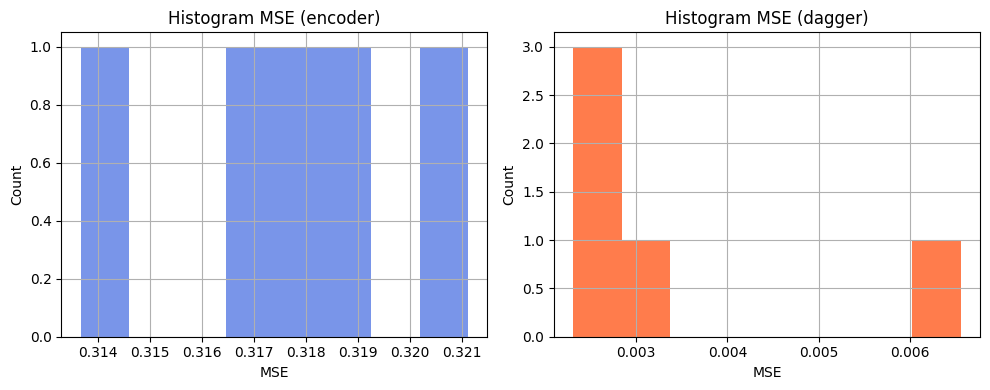

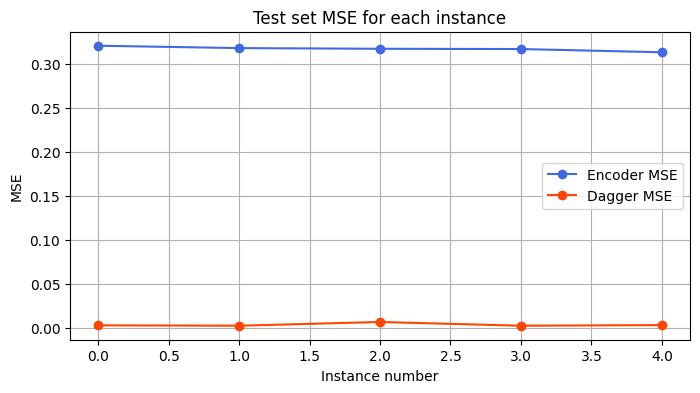

In [34]:
# --- STATISTICS AND PLOTS ---
all_mse_test = np.array(all_mse_test)
all_mse_test_dagger = np.array(all_mse_test_dagger)

print("\n=== Summary statistics for test MSE (encoder) ===")
print(f"Mean:   {all_mse_test.mean():.6f}")
print(f"Median: {np.median(all_mse_test):.6f}")
print(f"Std:    {all_mse_test.std():.6f}")
print(f"Min:    {all_mse_test.min():.6f}")
print(f"Max:    {all_mse_test.max():.6f}")

print("\n=== Summary statistics for test MSE (dagger) ===")
print(f"Mean:   {all_mse_test_dagger.mean():.6f}")
print(f"Median: {np.median(all_mse_test_dagger):.6f}")
print(f"Std:    {all_mse_test_dagger.std():.6f}")
print(f"Min:    {all_mse_test_dagger.min():.6f}")
print(f"Max:    {all_mse_test_dagger.max():.6f}")

# Histograms
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(all_mse_test, bins=8, color='royalblue', alpha=0.7)
plt.title("Histogram MSE (encoder)")
plt.xlabel("MSE")
plt.ylabel("Count")
plt.grid(True)

plt.subplot(1,2,2)
plt.hist(all_mse_test_dagger, bins=8, color='orangered', alpha=0.7)
plt.title("Histogram MSE (dagger)")
plt.xlabel("MSE")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()

# MSE comparison for each instance
plt.figure(figsize=(8,4))
plt.plot(all_mse_test, 'o-', label='Encoder MSE', color='royalblue')
plt.plot(all_mse_test_dagger, 'o-', label='Dagger MSE', color='orangered')
plt.title("Test set MSE for each instance")
plt.xlabel("Instance number")
plt.ylabel("MSE")
plt.legend()
plt.grid(True)
plt.show()


In [35]:
idx_repr = int(np.argmin(all_mse_test_dagger))

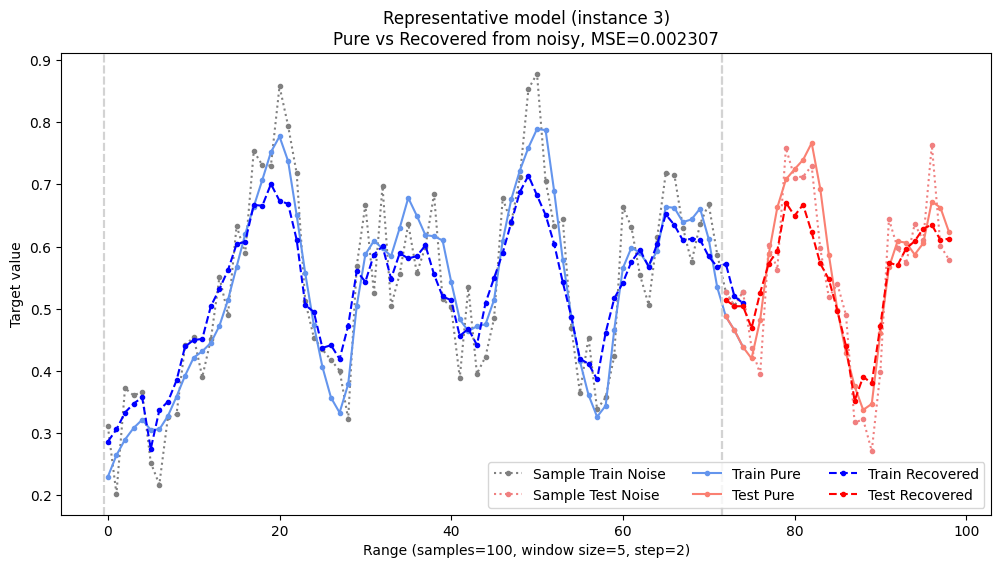

In [36]:
# --- Reconstruction plot as in multi_plot_flat_ts ---

# Reconstruct predictions on training and test set for the representative model
inst_seed_repr = inst_seeds[idx_repr]
np.random.seed(inst_seed_repr)
qae_dagger = half_qae_unified(wires, n_latent, n_trash, n_layers=n_layers, rot=rot, dagger=True)
dev = qml.device(sim, wires=wires, shots=shots, seed=inst_seed_repr)
half_qae_dagger_model = qml.QNode(qae_dagger, dev)
best_params_dagger = hist_params_dagger[stats_dagger[0]]

# Prepare tensors for train/test (NOISY!)
X_train_noisy_tens, y_train_noisy_tens, X_test_noisy_tens, y_test_noisy_tens = create_sw_tens(
    X, y, noise=noise, wind_size=wind_size, wind_step=wind_step
)
X_train_pure_tens, y_train_pure_tens, X_test_pure_tens, y_test_pure_tens = create_sw_tens(
    X, y, noise=0, wind_size=wind_size, wind_step=wind_step
)

# Reconstruction train/test FROM NOISY
pred_train_from_noisy_tens = np.stack([half_qae_dagger_model(best_params_dagger, x) for x in y_train_noisy_tens], requires_grad=False)
pred_test_from_noisy_tens = np.stack([half_qae_dagger_model(best_params_dagger, x) for x in y_test_noisy_tens], requires_grad=False)

# Flatten for plot
y_train_pure_flat = ts_wind_flatten_avg(y_train_pure_tens, wind_step)
y_test_pure_flat = ts_wind_flatten_avg(y_test_pure_tens, wind_step)
y_train_noisy_flat = ts_wind_flatten_avg(y_train_noisy_tens, wind_step)
y_test_noisy_flat = ts_wind_flatten_avg(y_test_noisy_tens, wind_step)
pred_train_from_noisy_flat = ts_wind_flatten_avg(pred_train_from_noisy_tens, wind_step)
pred_test_from_noisy_flat = ts_wind_flatten_avg(pred_test_from_noisy_tens, wind_step)

# Prepare data for plot
X_list = [X_train_pure_tens[0], X_test_pure_tens[0], X_train_pure_tens[0], X_test_pure_tens[0], X_train_pure_tens[0], X_test_pure_tens[0]]
y_list = [y_train_noisy_flat, y_test_noisy_flat, y_train_pure_flat, y_test_pure_flat, pred_train_from_noisy_flat, pred_test_from_noisy_flat]

multi_plot_flat_ts(
    y_list, X_list=X_list,
    colors=['gray', 'lightcoral', 'cornflowerblue', 'salmon', 'blue', 'red'],
    marker_colors=['gray', 'lightcoral', 'cornflowerblue', 'salmon', 'blue', 'red'],
    labels=[
        'Sample Train Noise',
        'Sample Test Noise',
        'Train Pure',
        'Test Pure',
        'Train Recovered',
        'Test Recovered'
    ],
    lines=['dotted', 'dotted', 'solid', 'solid', 'dashed', 'dashed'],
    markers=['.', '.', '.', '.', '.', '.'],
    legend_cols=3,
    title=f'Representative model (instance {idx_repr})\nPure vs Recovered from noisy, MSE={all_mse_test_dagger[idx_repr]:.6f}',
    xlabel=f'Range (samples={samples}, window size={wind_size}, step={wind_step})'
)

## GAUSS NOISE

In [37]:
def add_noise_gauss(vec, noise=0.0):
    if noise == 0:
        return vec
    else:
        rng = np.random.default_rng()
        noise_vec = rng.normal(loc=0.0, scale=noise, size=len(vec))
        return np.array(vec) + noise_vec

In [38]:
### Create time series tensor data with optional noise (note that windows overlap by wind_step)
def create_sw_tens(X, y, noise=0.0, wind_size=5, wind_step=2):
    y_ts = ts_wind_make(add_noise_gauss(y, noise), wind_size, wind_step)
    X_ts = np.array([i*wind_step for i in range(len(y_ts))])
    X_train_ts, y_train_ts, X_test_ts, y_test_ts = ts_wind_split(X_ts, y_ts, split)

    X_train_tens = np.tensor(X_train_ts, requires_grad=False)
    y_train_tens = np.tensor(y_train_ts, requires_grad=False)
    X_test_tens = np.tensor(X_test_ts, requires_grad=False)
    y_test_tens = np.tensor(y_test_ts, requires_grad=False)
    return X_train_tens, y_train_tens, X_test_tens, y_test_tens

In [39]:
qae = half_qae_unified(wires, n_latent, n_trash, n_layers=n_layers, rot=rot, dagger=False)
dev = qml.device(sim, wires=wires, shots=shots, seed=seed)
half_qae_model_unified = qml.QNode(qae, dev)

In [40]:
hist_cost, hist_params, init_weights, stats = train_with_noise_trash(
    half_qae_model_unified,
    X, y, mse_cost_on_tensors, opt, n_epochs,
    wind_size=wind_size, wind_step=wind_step, noise=noise,
    log_interv=log_interv, prompt_fract=0.1, start_time=0, level=2, seed=seed
)

Iter: 000 (001 sec) cost=0.202213
Iter: 010 (013 sec) cost=0.000666
Iter: 020 (025 sec) cost=0.002349
Iter: 030 (037 sec) cost=0.000709
Iter: 040 (049 sec) cost=0.000469
Iter: 050 (067 sec) cost=0.000141
Iter: 060 (093 sec) cost=5.6e-05
Iter: 070 (105 sec) cost=4.6e-05
Iter: 080 (118 sec) cost=3.7e-05
Iter: 090 (129 sec) cost=2.8e-05

Training completed: epochs=100, min cost=1.3e-05 @ 93, time=156 secs



In [41]:
best_params = hist_params[stats[0]]
best_params_flip = np.flip(best_params, axis=0) 

In [42]:
qae = half_qae_unified(wires, n_latent, n_trash, n_layers=n_layers, rot=rot, dagger=True)
dev = qml.device(sim, wires=wires, shots=shots, seed=seed)
half_qae_model_unified = qml.QNode(qae, dev)

In [43]:
hist_cost, hist_params, init_weights, stats = train_with_noise(
    half_qae_model_unified,
    X, y, mse_cost_on_tensors, opt, n_epochs,
    wind_size=wind_size, wind_step=wind_step, noise=noise, init_weights=best_params_flip,
    log_interv=log_interv, prompt_fract=0.1, start_time=0, level=2, seed=seed
)

Iter: 000 (003 sec) cost=0.24477
Iter: 010 (016 sec) cost=0.039719
Iter: 020 (028 sec) cost=0.018265
Iter: 030 (040 sec) cost=0.008093
Iter: 040 (053 sec) cost=0.006283
Iter: 050 (066 sec) cost=0.004629
Iter: 060 (078 sec) cost=0.004875
Iter: 070 (090 sec) cost=0.00365
Iter: 080 (103 sec) cost=0.003381
Iter: 090 (115 sec) cost=0.003182

Training completed: epochs=100, min cost=0.003065 @ 81, time=126 secs



In [44]:
best_params_dagger = hist_params[stats[0]]

MSE train pure vs noise vs recovered = 0.01071271, 0.00367131
MSE test  pure vs noise vs recovered = 0.01112757, 0.00339207



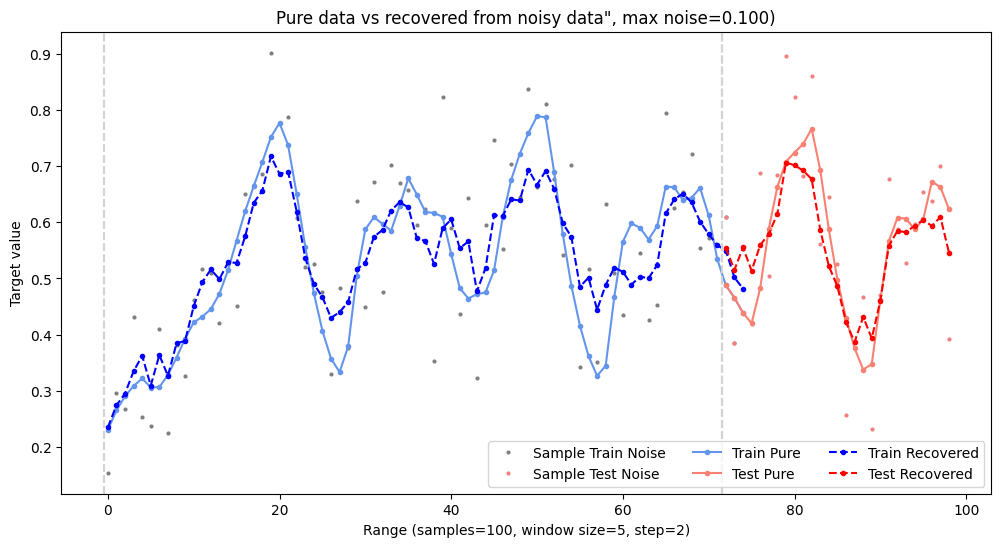

In [45]:
### Add noise to pure data to create a sample noisy data

# Create a sample of pure and noisy training and test tensors
X_train_pure_tens, y_train_pure_tens, X_test_pure_tens, y_test_pure_tens = \
    create_sw_tens(X, y, noise=0, wind_size=wind_size, wind_step=wind_step)
X_train_noisy_tens, y_train_noisy_tens, X_test_noisy_tens, y_test_noisy_tens = \
    create_sw_tens(X, y, noise=noise, wind_size=wind_size, wind_step=wind_step)

# Flatten original TSs for plotting
y_train_pure_flat = ts_wind_flatten_avg(y_train_pure_tens, wind_step)
y_test_pure_flat = ts_wind_flatten_avg(y_test_pure_tens, wind_step)
y_train_noisy_flat = ts_wind_flatten_avg(y_train_noisy_tens, wind_step)
y_test_noisy_flat = ts_wind_flatten_avg(y_test_noisy_tens, wind_step)


### Reconstruct pure and noisy training TSs
pred_train_from_pure_tens = np.stack([half_qae_model_unified(best_params_dagger, x) for x in y_train_pure_tens], requires_grad=False)
pred_test_from_pure_tens = np.stack([half_qae_model_unified(best_params_dagger, x) for x in y_test_pure_tens], requires_grad=False)
pred_train_from_noisy_tens = np.stack([half_qae_model_unified(best_params_dagger, x) for x in y_train_noisy_tens], requires_grad=False)
pred_test_from_noisy_tens = np.stack([half_qae_model_unified(best_params_dagger, x) for x in y_test_noisy_tens], requires_grad=False)

### Flatten recovered TSs
pred_train_from_pure_flat = ts_wind_flatten_avg(pred_train_from_pure_tens, wind_step)
pred_test_from_pure_flat = ts_wind_flatten_avg(pred_test_from_pure_tens, wind_step)
pred_train_from_noisy_flat = ts_wind_flatten_avg(pred_train_from_noisy_tens, wind_step)
pred_test_from_noisy_flat = ts_wind_flatten_avg(pred_test_from_noisy_tens, wind_step)


### Calculate metrics to show in charts
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score           
mse_train_pure_vs_noisy = mean_squared_error(y_train_pure_flat, y_train_noisy_flat)
mse_train_pure_vs_rec_from_noisy = mean_squared_error(y_train_pure_flat, pred_train_from_noisy_flat)
mse_test_pure_vs_noisy = mean_squared_error(y_test_pure_flat, y_test_noisy_flat)
mse_test_pure_vs_rec_from_noisy = mean_squared_error(y_test_pure_flat, pred_test_from_noisy_flat)   
print(f'MSE train pure vs noise vs recovered = {mse_train_pure_vs_noisy:0.8f}, {mse_train_pure_vs_rec_from_noisy:0.8f}')
print(f'MSE test  pure vs noise vs recovered = {mse_test_pure_vs_noisy:0.8f}, {mse_test_pure_vs_rec_from_noisy:0.8f}')  

### Plot the original and recovered data with added performance metrics
# Prepare X, y lists for plotting
X_list = [X_train_pure_tens[0], X_test_pure_tens[0], 
          X_train_pure_tens[0], X_test_pure_tens[0],        
            X_train_pure_tens[0], X_test_pure_tens[0]]      
y_list = [y_train_noisy_flat, y_test_noisy_flat,
          y_train_pure_flat, y_test_pure_flat,
            pred_train_from_noisy_flat, pred_test_from_noisy_flat]  
print()
multi_plot_flat_ts(
    y_list, X_list=X_list,
    colors=['none', 'none', 'cornflowerblue', 'salmon', 'blue', 'red'],
    marker_colors=['gray', 'lightcoral', 'cornflowerblue', 'salmon', 'blue', 'red'],
    labels=[
        'Sample Train Noise',
        'Sample Test Noise',
        'Train Pure',
        'Test Pure',
        'Train Recovered',
        'Test Recovered'
    ],
    lines=['dotted', 'dotted', 'solid', 'solid', 'dashed', 'dashed'],
    markers=['.', '.', '.', '.', '.', '.'],
    legend_cols=3,
    title=f'Pure data vs recovered from noisy data\", max noise={noise:0.3f})',
    xlabel=f'Range (samples={samples}, window size={wind_size}, step={wind_step})',
    #save_plot=f'{FIGURES_PATH}/{TRAIN_PREF}/train_org_vs_recovered.eps'
)
print()

In [46]:
# Wiener filter
filtered_wiener = wiener(y_train_noisy_flat)

# Savitzky-Golay filter
filtered_savgol = savgol_filter(y_train_noisy_flat, window_length=7, polyorder=2)

# Butterworth (low-pass)
b, a = butter(N=3, Wn=0.1)
filtered_butter = filtfilt(b, a, y_train_noisy_flat)

# Median filter
filtered_median = medfilt(y_train_noisy_flat, kernel_size=5)

# Moving average
window = 5
filtered_ma = np.convolve(y_train_noisy_flat, np.ones(window)/window, mode='same')

# MSE comparison
from sklearn.metrics import mean_squared_error
print("Wiener MSE:", mean_squared_error(y_train_pure_flat, filtered_wiener))
print("Savitzky-Golay MSE:", mean_squared_error(y_train_pure_flat, filtered_savgol))
print("Butterworth MSE:", mean_squared_error(y_train_pure_flat, filtered_butter))
print("Median MSE:", mean_squared_error(y_train_pure_flat, filtered_median))
print("Moving average MSE:", mean_squared_error(y_train_pure_flat, filtered_ma))
print("Quantum autoencoder MSE:", mean_squared_error(y_train_pure_flat, pred_train_from_noisy_flat))

Wiener MSE: 0.004474864072711705
Savitzky-Golay MSE: 0.003043273530793979
Butterworth MSE: 0.008530070552609133
Median MSE: 0.005162283844704162
Moving average MSE: 0.003284838583640204
Quantum autoencoder MSE: 0.0036713119453926865


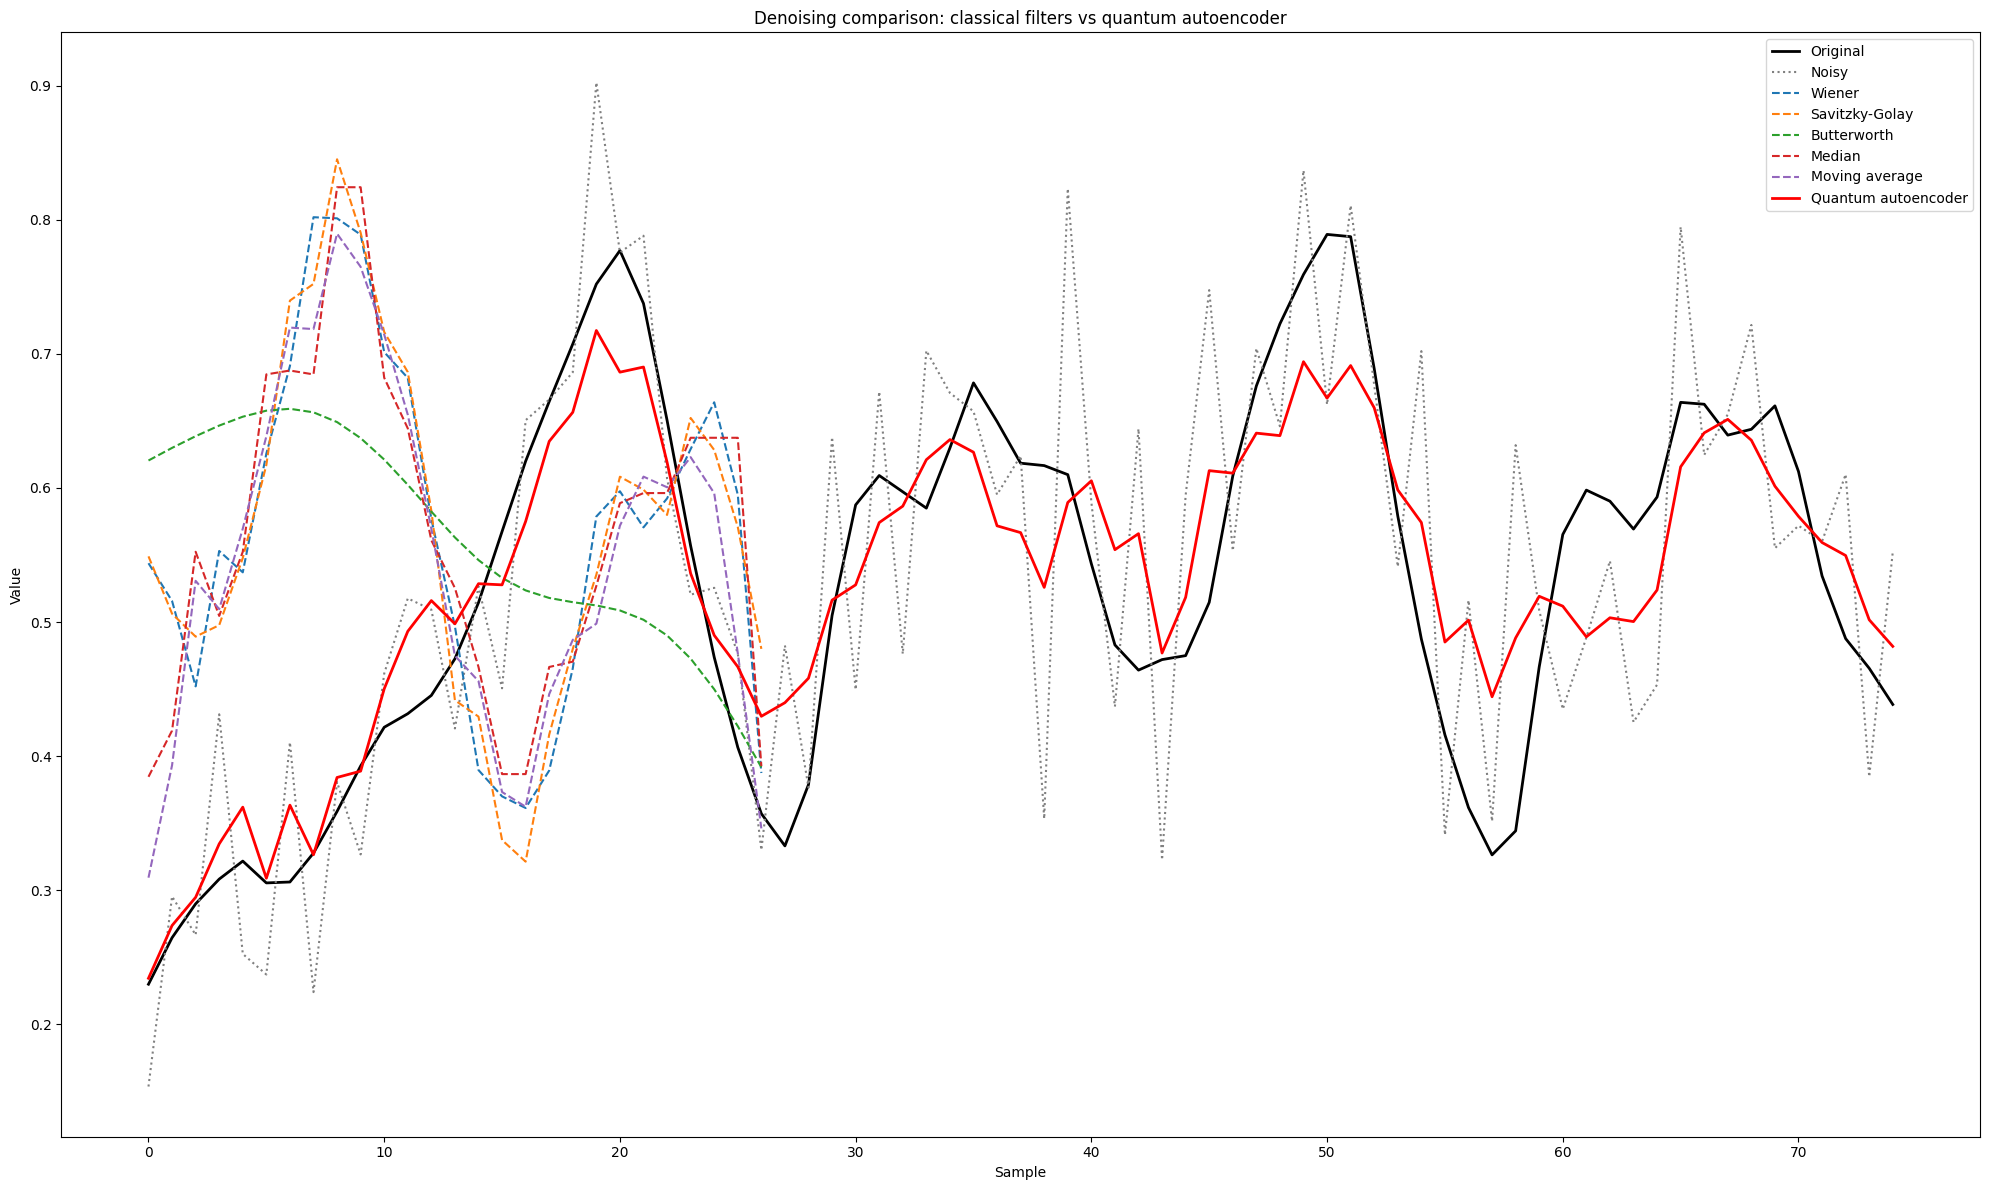

In [51]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 12))
plt.plot(y_train_pure_flat, label='Original', color='black', linewidth=2)
plt.plot(y_train_noisy_flat, label='Noisy', color='gray', linestyle='dotted')
plt.plot(filtered_wiener, label='Wiener', linestyle='dashed')
plt.plot(filtered_savgol, label='Savitzky-Golay', linestyle='dashed')
plt.plot(filtered_butter, label='Butterworth', linestyle='dashed')
plt.plot(filtered_median, label='Median', linestyle='dashed')
plt.plot(filtered_ma, label='Moving average', linestyle='dashed')
plt.plot(pred_train_from_noisy_flat, label='Quantum autoencoder', color='red', linewidth=2)

plt.legend()
plt.title('Denoising comparison: classical filters vs quantum autoencoder')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.tight_layout()
plt.show()

In [48]:
# Wiener filter
filtered_wiener = wiener(y_test_noisy_flat)

# Savitzky-Golay filter
filtered_savgol = savgol_filter(y_test_noisy_flat, window_length=7, polyorder=2)

# Butterworth (low-pass)
b, a = butter(N=3, Wn=0.1)
filtered_butter = filtfilt(b, a, y_test_noisy_flat)

# Median filter
filtered_median = medfilt(y_test_noisy_flat, kernel_size=5)

# Moving average
window = 5
filtered_ma = np.convolve(y_test_noisy_flat, np.ones(window)/window, mode='same')

# MSE comparison
from sklearn.metrics import mean_squared_error
print("Wiener MSE:", mean_squared_error(y_test_pure_flat, filtered_wiener))
print("Savitzky-Golay MSE:", mean_squared_error(y_test_pure_flat, filtered_savgol))
print("Butterworth MSE:", mean_squared_error(y_test_pure_flat, filtered_butter))
print("Median MSE:", mean_squared_error(y_test_pure_flat, filtered_median))
print("Moving average MSE:", mean_squared_error(y_test_pure_flat, filtered_ma))
print("Quantum autoencoder MSE:", mean_squared_error(y_test_pure_flat, pred_test_from_noisy_flat))

Wiener MSE: 0.004322495854555222
Savitzky-Golay MSE: 0.003362194078982112
Butterworth MSE: 0.01997193021134128
Median MSE: 0.005661010199359057
Moving average MSE: 0.007864009210292513
Quantum autoencoder MSE: 0.00339207005910181


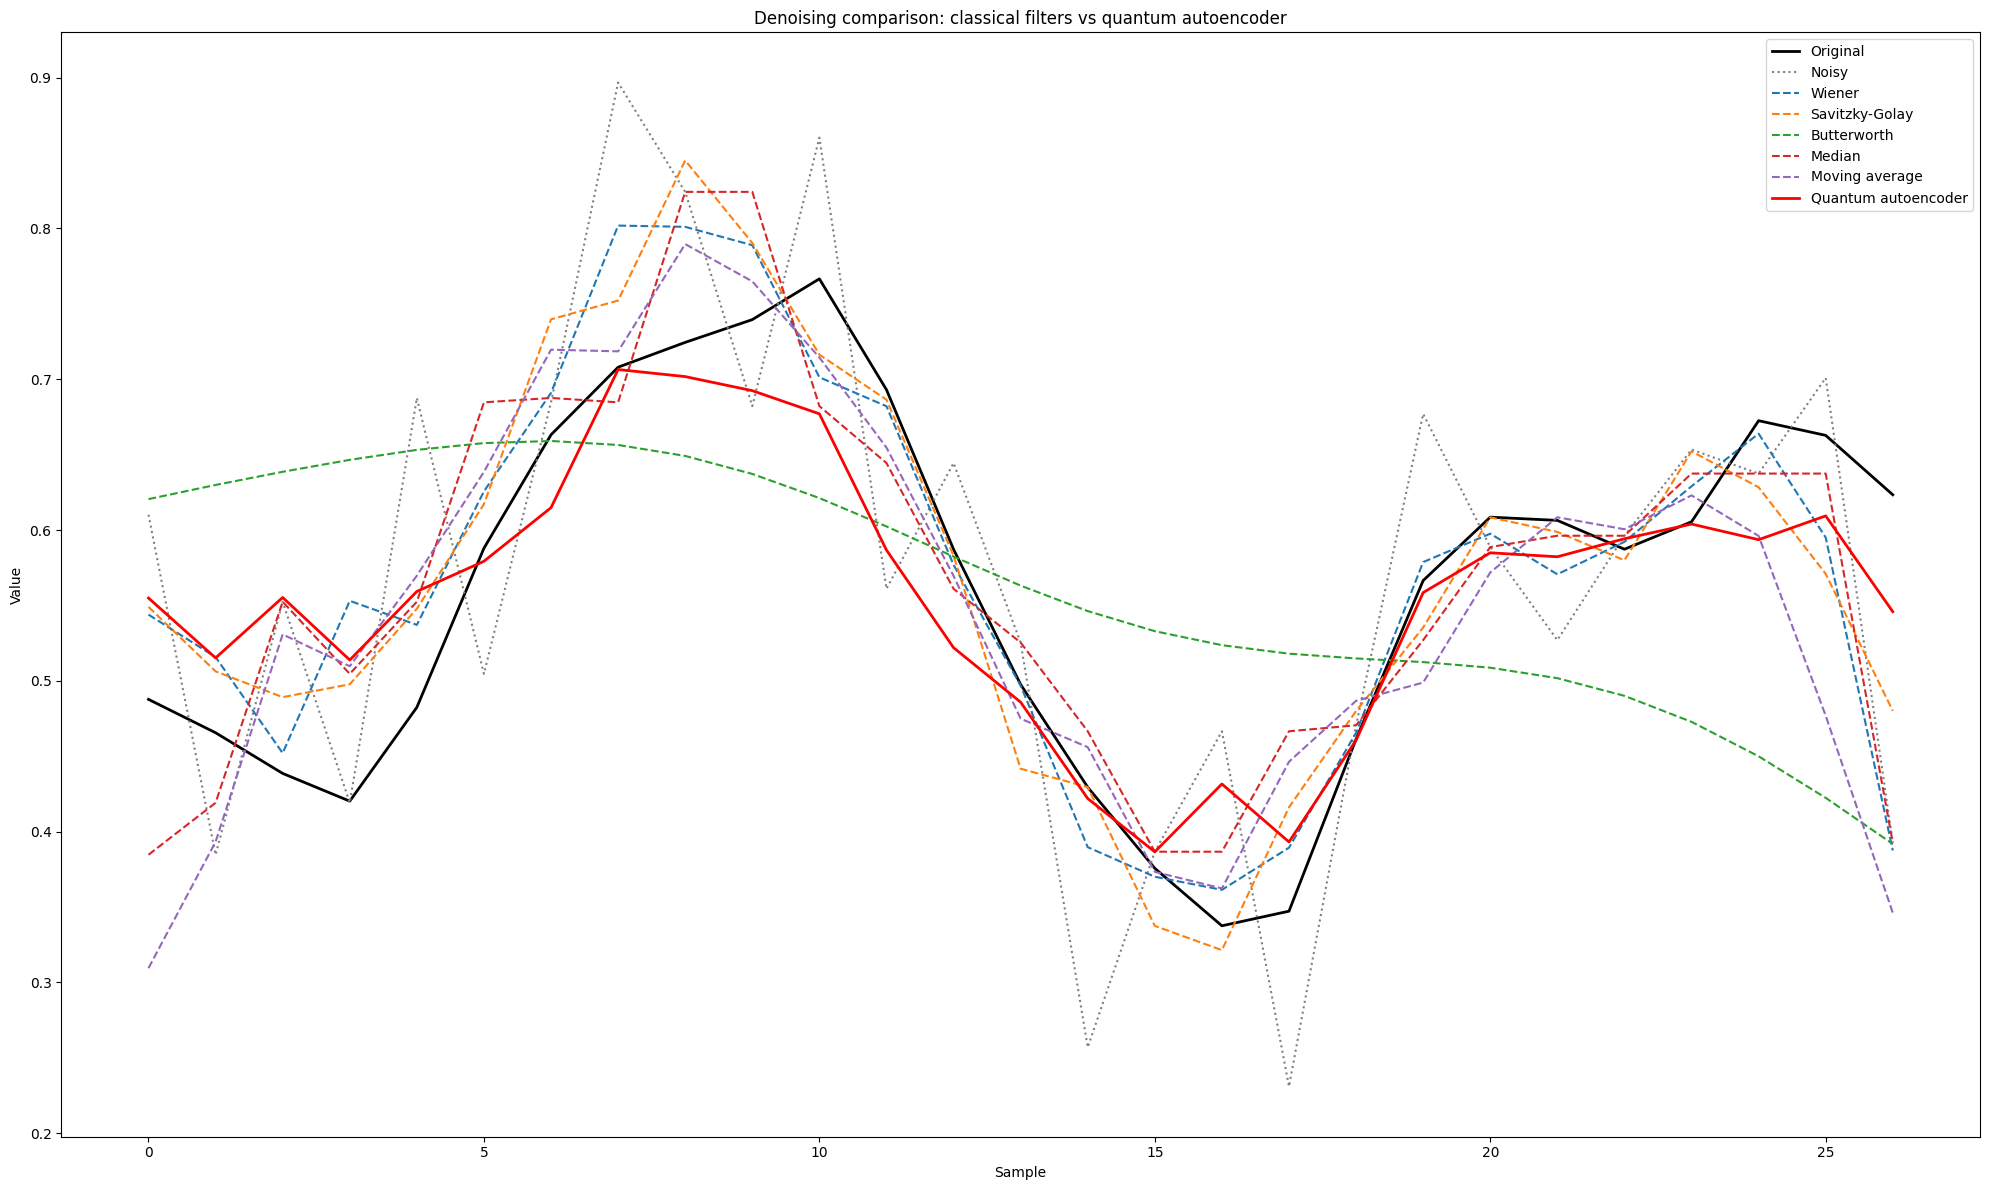

In [52]:
plt.figure(figsize=(20, 12))
plt.plot(y_test_pure_flat, label='Original', color='black', linewidth=2)
plt.plot(y_test_noisy_flat, label='Noisy', color='gray', linestyle='dotted')
plt.plot(filtered_wiener, label='Wiener', linestyle='dashed')
plt.plot(filtered_savgol, label='Savitzky-Golay', linestyle='dashed')
plt.plot(filtered_butter, label='Butterworth', linestyle='dashed')
plt.plot(filtered_median, label='Median', linestyle='dashed')
plt.plot(filtered_ma, label='Moving average', linestyle='dashed')
plt.plot(pred_test_from_noisy_flat, label='Quantum autoencoder', color='red', linewidth=2)

plt.legend()
plt.title('Denoising comparison: classical filters vs quantum autoencoder')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.tight_layout()
plt.show()

In [53]:
def compute_snr(signal, noise):

    power_signal = np.mean(np.square(signal))
    power_noise = np.mean(np.square(noise))
    snr = 10 * np.log10(power_signal / power_noise)
    return snr

# Example usage:
noise = y_train_noisy_flat - y_train_pure_flat
snr_db = compute_snr(y_train_pure_flat, noise)
print(f"SNR = {snr_db:.2f} dB")

SNR = 14.48 dB


## AE

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim

In [12]:
# Simple autoencoder
class SimpleAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.GELU(),
            nn.Linear(16, latent_dim),
            nn.GELU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 16),
            nn.GELU(),
            nn.Linear(16, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)



In [18]:
### Create time series tensor data with optional noise (note that windows overlap by wind_step)
def create_sw_tens(X, y, noise=0.0, wind_size=5, wind_step=2):
    y_ts = ts_wind_make(ts_add_noise(y, noise), wind_size, wind_step)
    X_ts = np.array([i*wind_step for i in range(len(y_ts))])
    X_train_ts, y_train_ts, X_test_ts, y_test_ts = ts_wind_split(X_ts, y_ts, split)

    X_train_tens = torch.tensor(X_train_ts, dtype=torch.float32, requires_grad=False)
    y_train_tens = torch.tensor(y_train_ts, dtype=torch.float32, requires_grad=False)
    X_test_tens = torch.tensor(X_test_ts, dtype=torch.float32, requires_grad=False)
    y_test_tens = torch.tensor(y_test_ts, dtype=torch.float32, requires_grad=False)
    return X_train_tens, y_train_tens, X_test_tens, y_test_tens

In [19]:
X_train_tens, y_train_tens, X_test_tens, y_test_tens = create_sw_tens(X, y, noise=0, wind_size=wind_size, wind_step=wind_step)

In [20]:
input_dim = y_train_tens.shape[1]
latent_dim = 3  # or another value

In [21]:
model = SimpleAutoencoder(input_dim, latent_dim)
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()
n_epochs = 100

Epoch 0, Loss: 0.347861
Epoch 20, Loss: 0.033382
Epoch 40, Loss: 0.018933
Epoch 60, Loss: 0.017980
Epoch 80, Loss: 0.016448


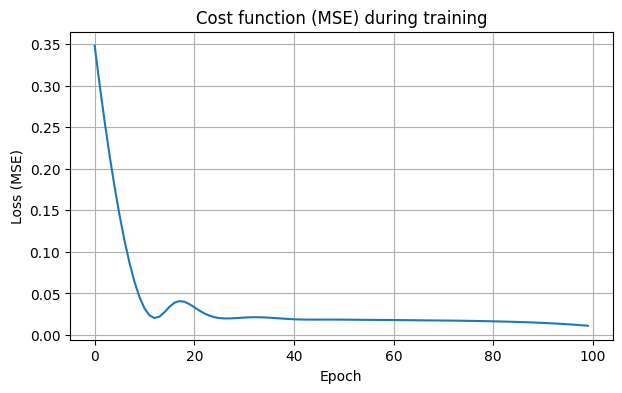

In [22]:
loss_history = []
for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()
    output = model(y_train_tens)
    loss = loss_fn(output, y_train_tens)
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())
    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

# Cost function plot
plt.figure(figsize=(7,4))
plt.plot(loss_history)
plt.title('Cost function (MSE) during training')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.grid(True)
plt.show()

In [23]:
# Reconstruction and evaluation
model.eval()
with torch.no_grad():
    rec_train = model(y_train_tens).numpy()
    rec_test = model(y_test_tens).numpy()

from sklearn.metrics import mean_squared_error
mse_train = mean_squared_error(y_train_tens.numpy(), rec_train)
mse_test = mean_squared_error(y_test_tens.numpy(), rec_test)
print(f"MSE train: {mse_train:.6f}")
print(f"MSE test:  {mse_test:.6f}")

MSE train: 0.010663
MSE test:  0.010015


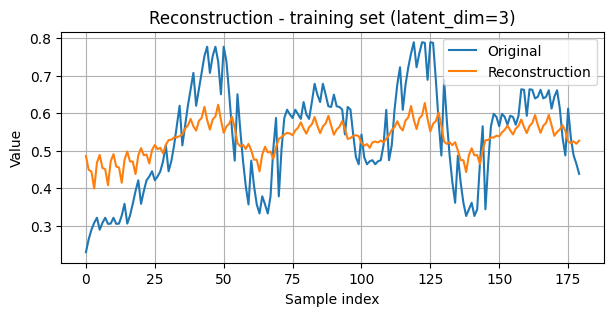

In [24]:
plt.figure(figsize=(7,3))
plt.plot(y_train_tens.numpy().flatten(), label='Original')
plt.plot(rec_train.flatten(), label='Reconstruction')
plt.title(f'Reconstruction - training set (latent_dim={latent_dim})')
plt.xlabel('Sample index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

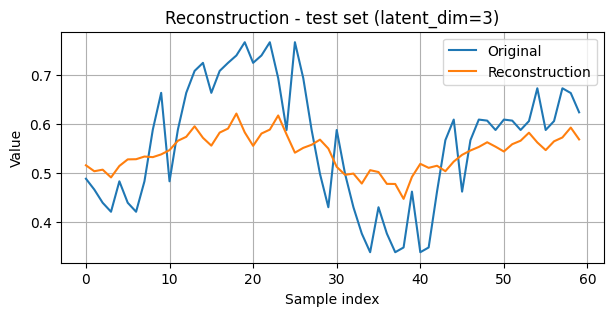

In [25]:
plt.figure(figsize=(7,3))
#plt.plot(y_train_tens.numpy().flatten(), label='Original')
plt.plot(y_test_tens.numpy().flatten(), label='Original')
#plt.plot(rec_train.flatten(), label='Reconstruction')
plt.plot(rec_test.flatten(), label='Reconstruction')
plt.title(f'Reconstruction - test set (latent_dim={latent_dim})')
plt.xlabel('Sample index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
class SimpleAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.BatchNorm1d(32),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(32, latent_dim),
            nn.BatchNorm1d(latent_dim),
            nn.GELU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.BatchNorm1d(32),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(32, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

Epoch 0, Loss: 0.010663
Epoch 20, Loss: 0.004674
Epoch 40, Loss: 0.002474
Epoch 60, Loss: 0.000758
Epoch 80, Loss: 0.000601


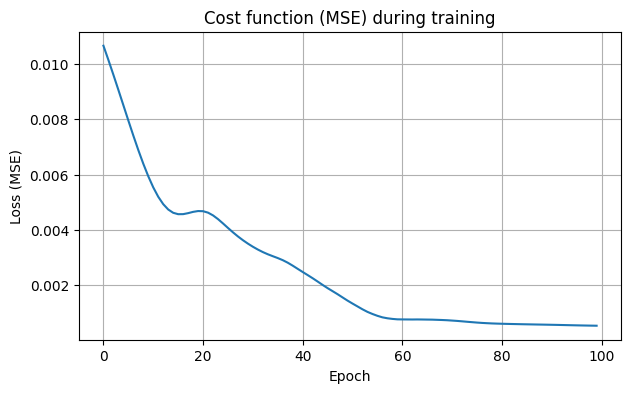

In [27]:
loss_history = []
for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()
    output = model(y_train_tens)
    loss = loss_fn(output, y_train_tens)
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())
    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

# Cost function plot
plt.figure(figsize=(7,4))
plt.plot(loss_history)
plt.title('Cost function (MSE) during training')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.grid(True)
plt.show()

In [28]:
# Reconstruction and evaluation
model.eval()
with torch.no_grad():
    rec_train = model(y_train_tens).numpy()
    rec_test = model(y_test_tens).numpy()

from sklearn.metrics import mean_squared_error
mse_train = mean_squared_error(y_train_tens.numpy(), rec_train)
mse_test = mean_squared_error(y_test_tens.numpy(), rec_test)
print(f"MSE train: {mse_train:.6f}")
print(f"MSE test:  {mse_test:.6f}")

MSE train: 0.000527
MSE test:  0.000768


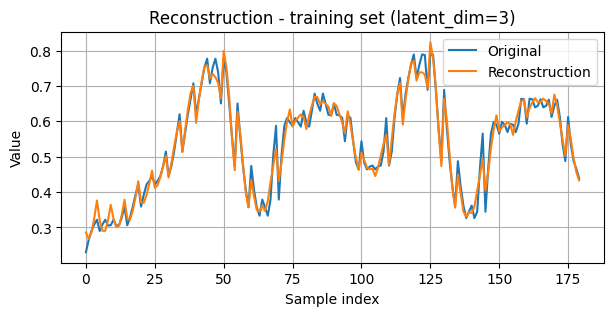

In [29]:
plt.figure(figsize=(7,3))
plt.plot(y_train_tens.numpy().flatten(), label='Original')
plt.plot(rec_train.flatten(), label='Reconstruction')
plt.title(f'Reconstruction - training set (latent_dim={latent_dim})')
plt.xlabel('Sample index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

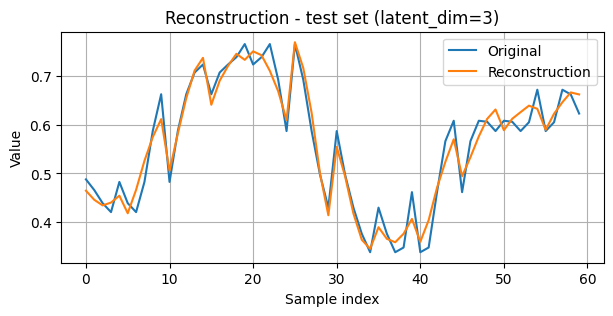

In [30]:
plt.figure(figsize=(7,3))
#plt.plot(y_train_tens.numpy().flatten(), label='Original')
plt.plot(y_test_tens.numpy().flatten(), label='Original')
#plt.plot(rec_train.flatten(), label='Rekonstrukcja')
plt.plot(rec_test.flatten(), label='Reconstruction')
plt.title(f'Reconstruction - test set (latent_dim={latent_dim})')
plt.xlabel('Sample index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [31]:
X_train_tens, y_train_tens, X_test_tens, y_test_tens = create_sw_tens(X, y, noise=noise, wind_size=wind_size, wind_step=wind_step)

Epoch 0, Loss: 0.002896
Epoch 20, Loss: 0.002669
Epoch 40, Loss: 0.002551
Epoch 60, Loss: 0.002493
Epoch 80, Loss: 0.002456


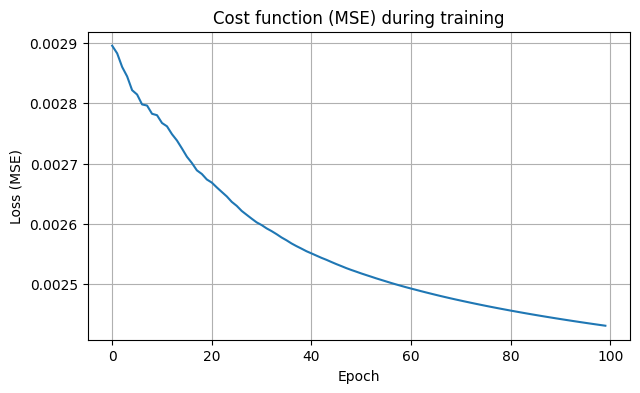

In [32]:
loss_history = []
for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()
    output = model(y_train_tens)
    loss = loss_fn(output, y_train_tens)
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())
    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

# Cost function plot
plt.figure(figsize=(7,4))
plt.plot(loss_history)
plt.title('Cost function (MSE) during training')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.grid(True)
plt.show()

In [33]:
# Reconstruction and evaluation
model.eval()
with torch.no_grad():
    rec_train = model(y_train_tens).numpy()
    rec_test = model(y_test_tens).numpy()

from sklearn.metrics import mean_squared_error
mse_train = mean_squared_error(y_train_tens.numpy(), rec_train)
mse_test = mean_squared_error(y_test_tens.numpy(), rec_test)
print(f"MSE train: {mse_train:.6f}")
print(f"MSE test:  {mse_test:.6f}")

MSE train: 0.002430
MSE test:  0.003115


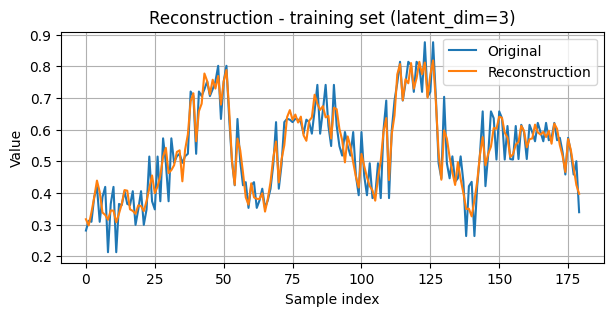

In [34]:
plt.figure(figsize=(7,3))
plt.plot(y_train_tens.numpy().flatten(), label='Original')
plt.plot(rec_train.flatten(), label='Reconstruction')
plt.title(f'Reconstruction - training set (latent_dim={latent_dim})')
plt.xlabel('Sample index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

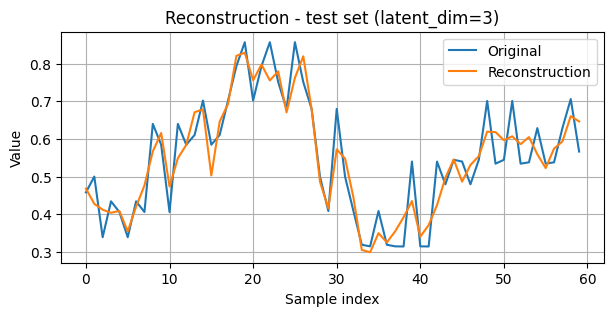

In [35]:
plt.figure(figsize=(7,3))
#plt.plot(y_train_tens.numpy().flatten(), label='Original')
plt.plot(y_test_tens.numpy().flatten(), label='Original')
#plt.plot(rec_train.flatten(), label='Rekonstrukcja')
plt.plot(rec_test.flatten(), label='Reconstruction')
plt.title(f'Reconstruction - test set (latent_dim={latent_dim})')
plt.xlabel('Sample index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [36]:
from scipy.signal import wiener, savgol_filter, butter, filtfilt, medfilt

In [37]:
# Wiener
filtered_wiener = wiener(y_test_tens.numpy().flatten())

# Savitzky-Golay
filtered_savgol = savgol_filter(y_test_tens.numpy().flatten(), window_length=7, polyorder=2)

# Butterworth (low-pass)
b, a = butter(N=3, Wn=0.1)
filtered_butter = filtfilt(b, a, y_test_tens.numpy().flatten())

# Median filter
filtered_median = medfilt(y_test_tens.numpy().flatten(), kernel_size=5)

# Moving average
window = 5
filtered_ma = np.convolve(y_test_tens.numpy().flatten(), np.ones(window)/window, mode='same')

In [38]:
# MSE comparison
from sklearn.metrics import mean_squared_error
print("Wiener MSE:", mean_squared_error(y_test_tens.numpy().flatten(), filtered_wiener))
print("Savitzky-Golay MSE:", mean_squared_error(y_test_tens.numpy().flatten(), filtered_savgol))
print("Butterworth MSE:", mean_squared_error(y_test_tens.numpy().flatten(), filtered_butter))
print("Median filter MSE:", mean_squared_error(y_test_tens.numpy().flatten(), filtered_median))
print("Moving average MSE:", mean_squared_error(y_test_tens.numpy().flatten(), filtered_ma))
print("Autoencoder MSE:", mean_squared_error(y_test_tens.numpy().flatten(), rec_test.flatten()))

Wiener MSE: 0.002979974617145141
Savitzky-Golay MSE: 0.005429646000266075
Butterworth MSE: 0.006106208780918007
Median filter MSE: 0.007706246804445982
Moving average MSE: 0.008649679209620826
Autoencoder MSE: 0.003114986466243863


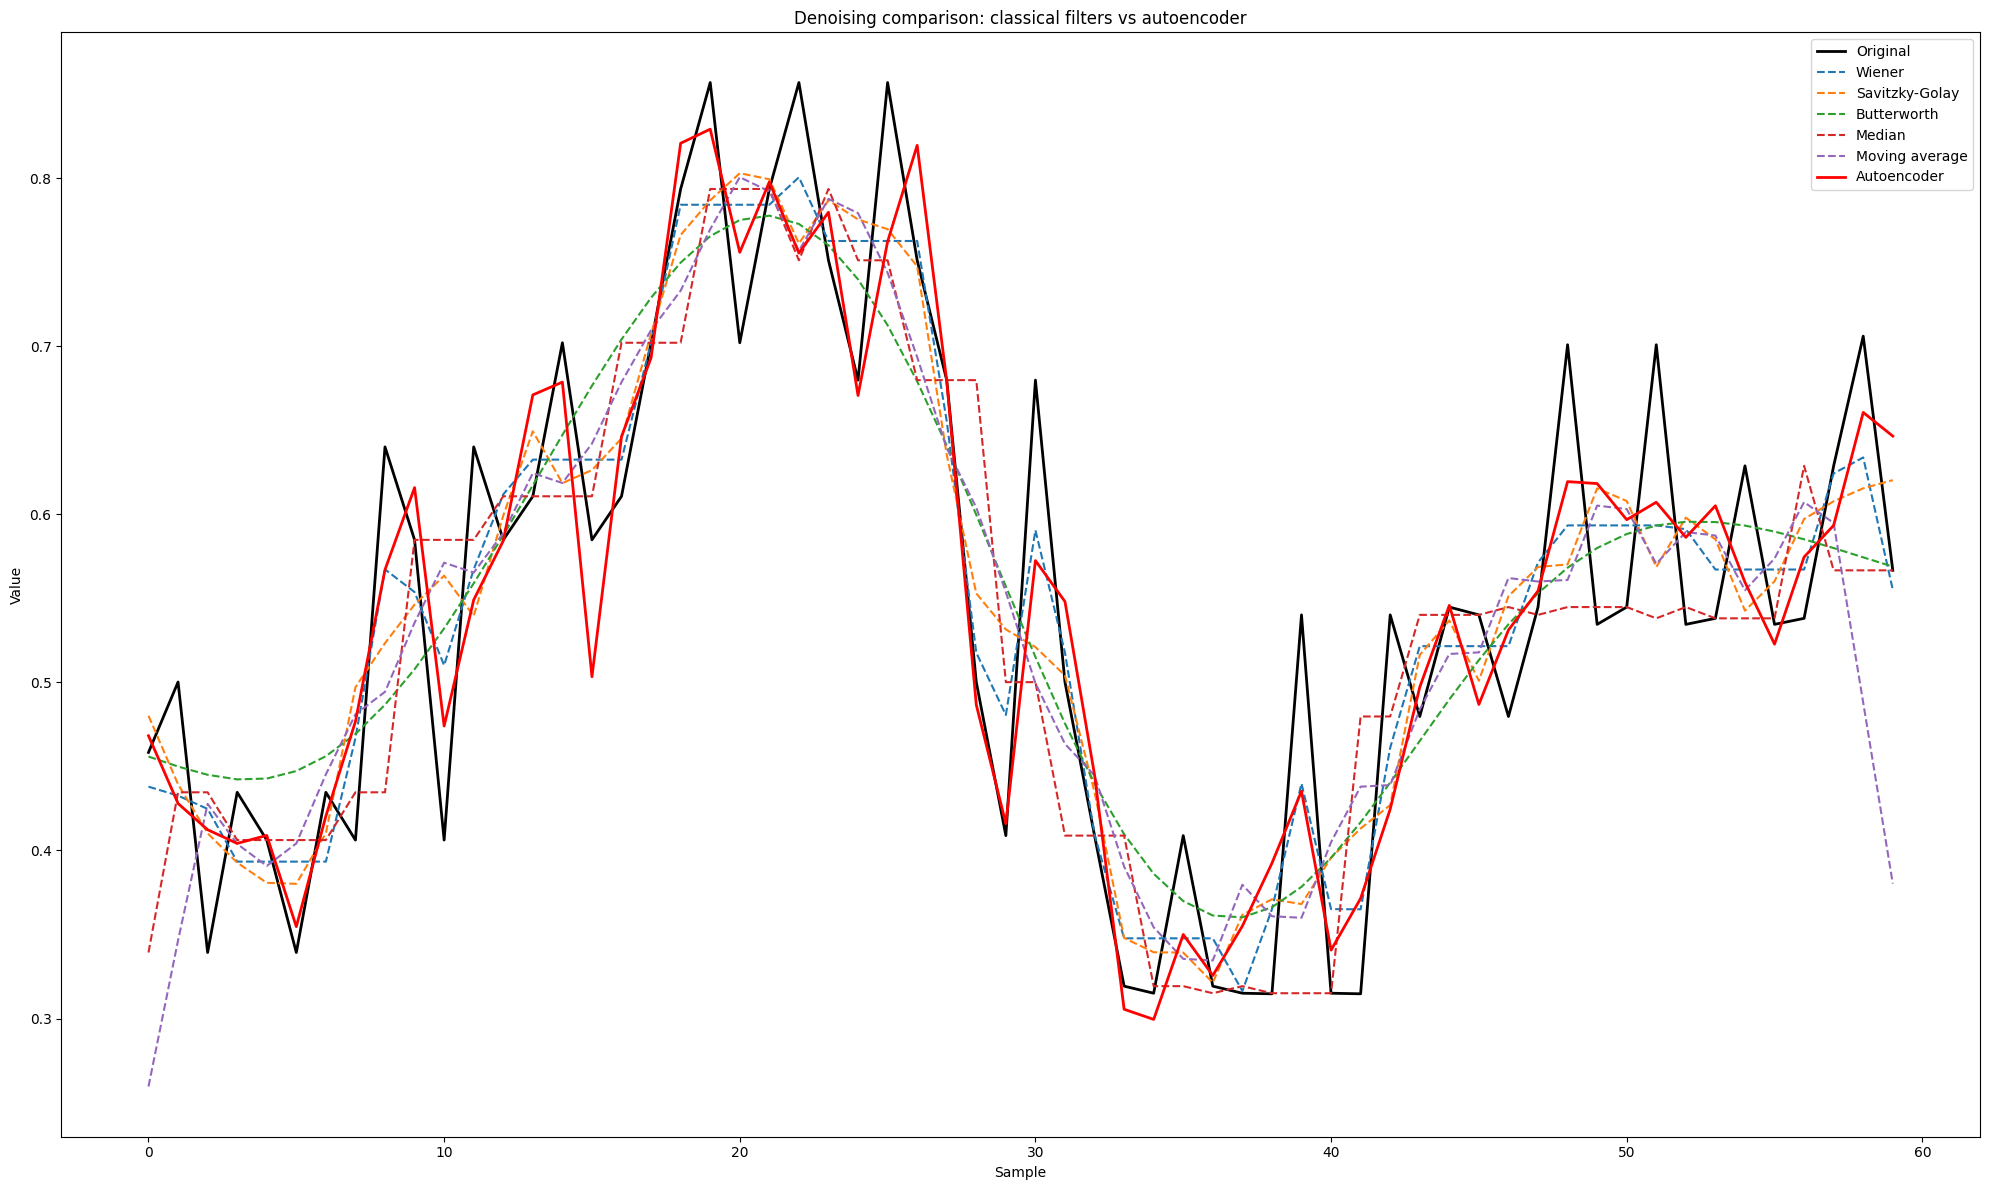

In [40]:
# Plot all results for comparison
plt.figure(figsize=(20, 12))
plt.plot(y_test_tens.numpy().flatten(), label='Original', color='black', linewidth=2)
plt.plot(filtered_wiener, label='Wiener', linestyle='dashed')
plt.plot(filtered_savgol, label='Savitzky-Golay', linestyle='dashed')
plt.plot(filtered_butter, label='Butterworth', linestyle='dashed')
plt.plot(filtered_median, label='Median', linestyle='dashed')
plt.plot(filtered_ma, label='Moving average', linestyle='dashed')
plt.plot(rec_test.flatten(), label='Autoencoder', color='red', linewidth=2)

plt.legend()
plt.title('Denoising comparison: classical filters vs autoencoder')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.tight_layout()
plt.show()